# Step-by-Step Research implementation Ensemble Model

Label mapping: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.463032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8718
[LightGBM] [Info] Number of data points in the train set: 85691, number of used features: 2552
[LightGBM] [Info] Start training from score -0.617681
[LightGBM] [Info] Start training from score -1.214032
[LightGBM] [Info] Start training from score -2.009445
[LightGBM] [Info] Start training from score -3.515047


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.427897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8718
[LightGBM] [Info] Number of data points in the train set: 85691, number of used features: 2552
[LightGBM] [Info] Start training from score -0.617681
[LightGBM] [Info] Start training from score -1.214032
[LightGBM] [Info] Start training from score -2.009445
[LightGBM] [Info] Start training from score -3.515047
XGBoost - Accuracy: 0.9426, Error Rate: 0.0574, Precision: 0.9361, Recall: 0.8528, F1 Score: 0.8886


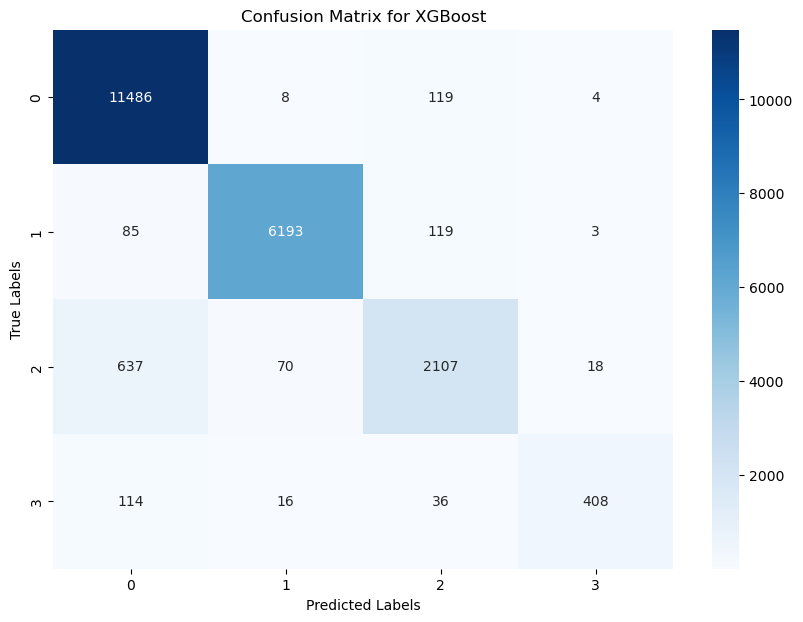

AdaBoost - Accuracy: 0.8481, Error Rate: 0.1519, Precision: 0.8072, Recall: 0.6792, F1 Score: 0.7221


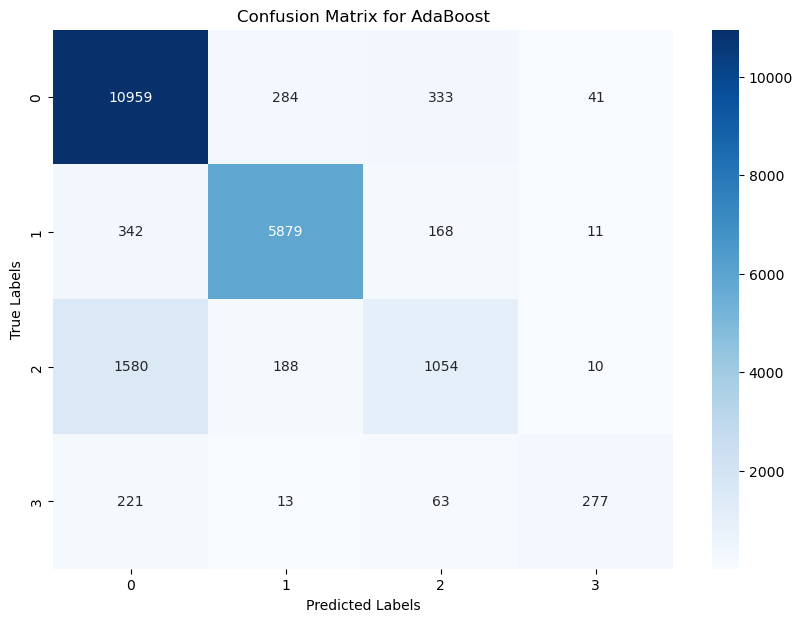

LightGBM - Accuracy: 0.9478, Error Rate: 0.0522, Precision: 0.9320, Recall: 0.8693, F1 Score: 0.8974


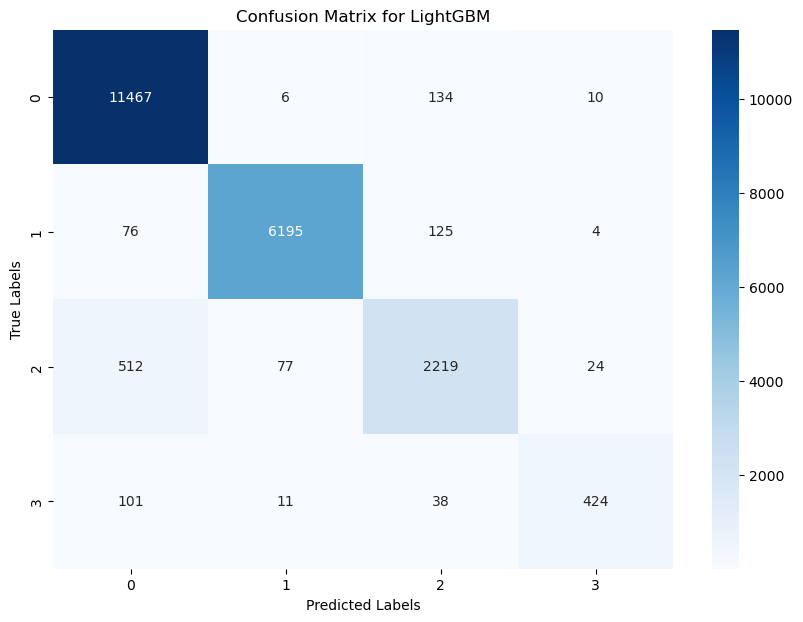

CatBoost - Accuracy: 0.9329, Error Rate: 0.0671, Precision: 0.9338, Recall: 0.8235, F1 Score: 0.8678


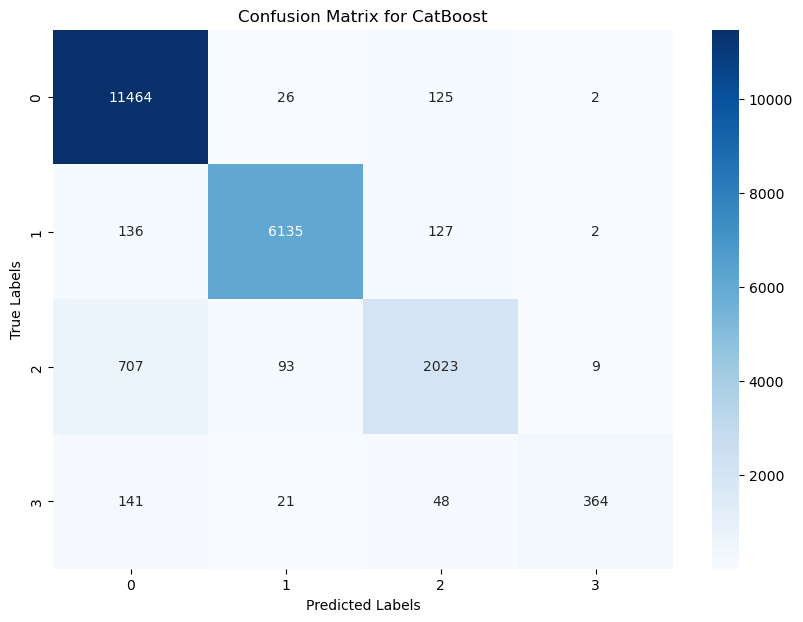

Ensemble - Accuracy: 0.9440, Error Rate: 0.0560, Precision: 0.9367, Recall: 0.8511, F1 Score: 0.8876


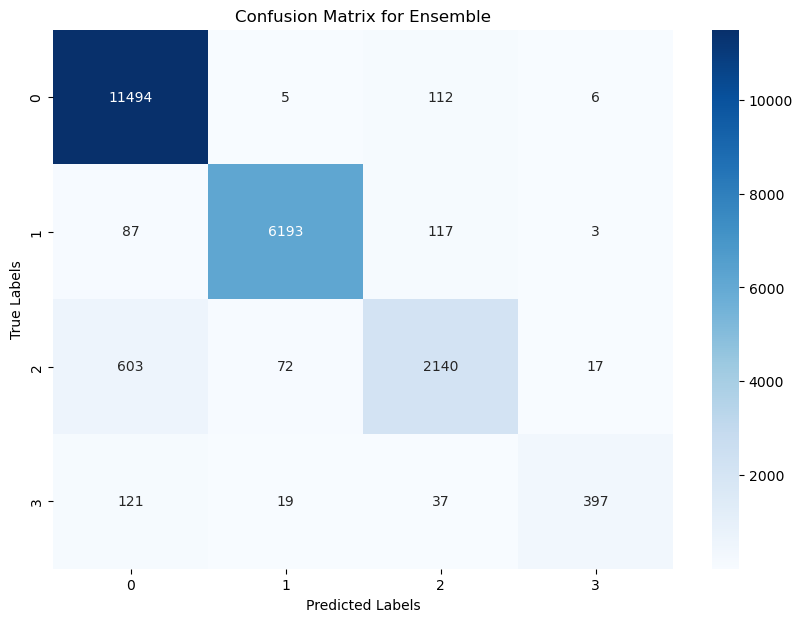

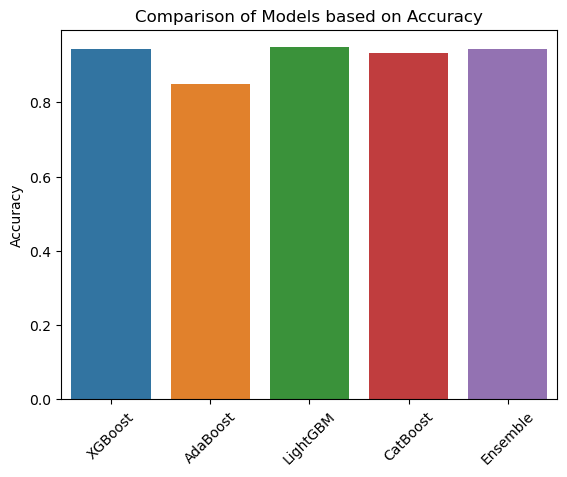

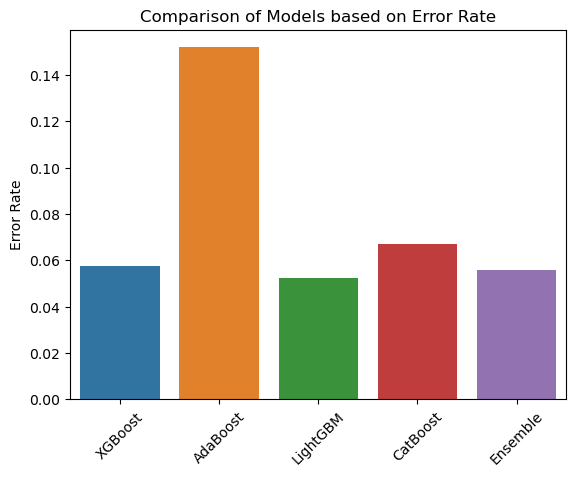

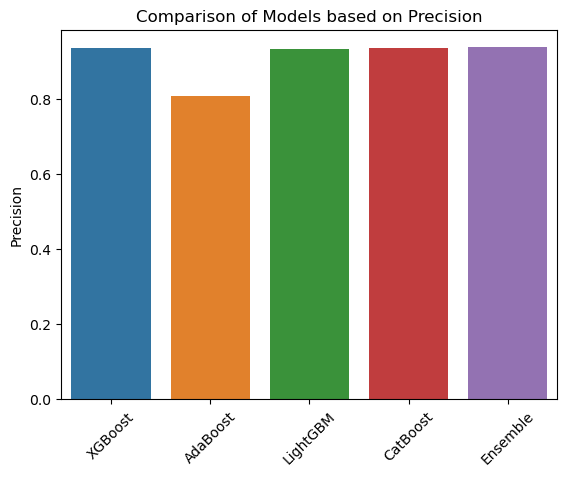

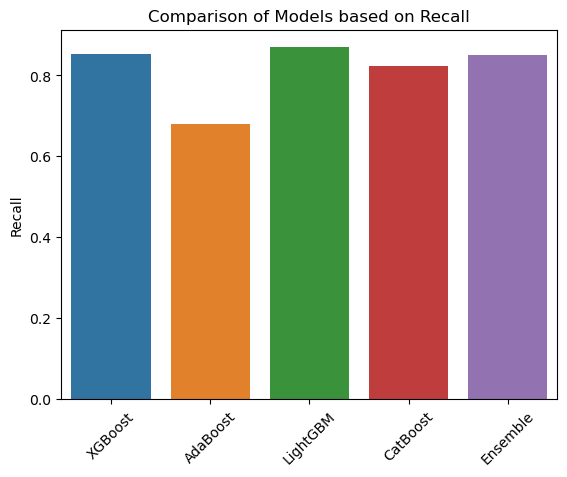

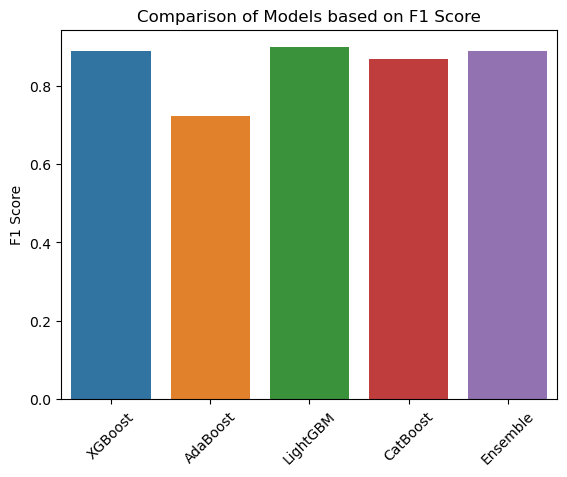

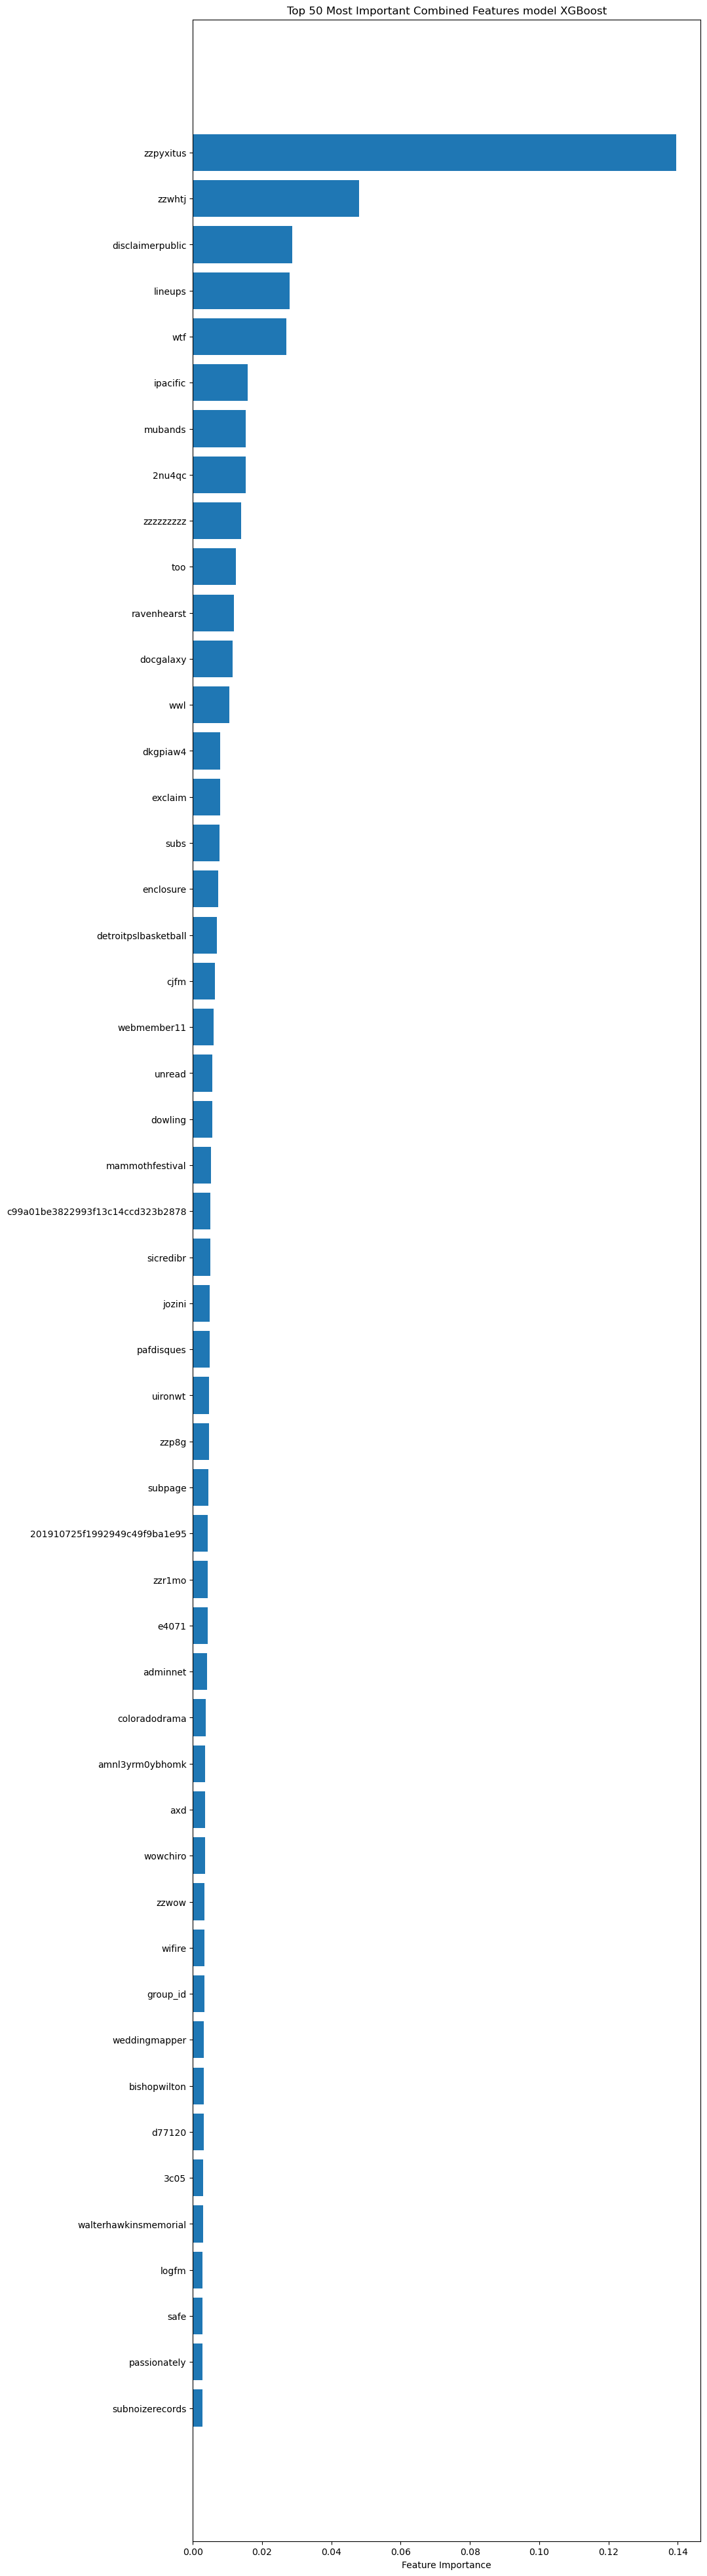

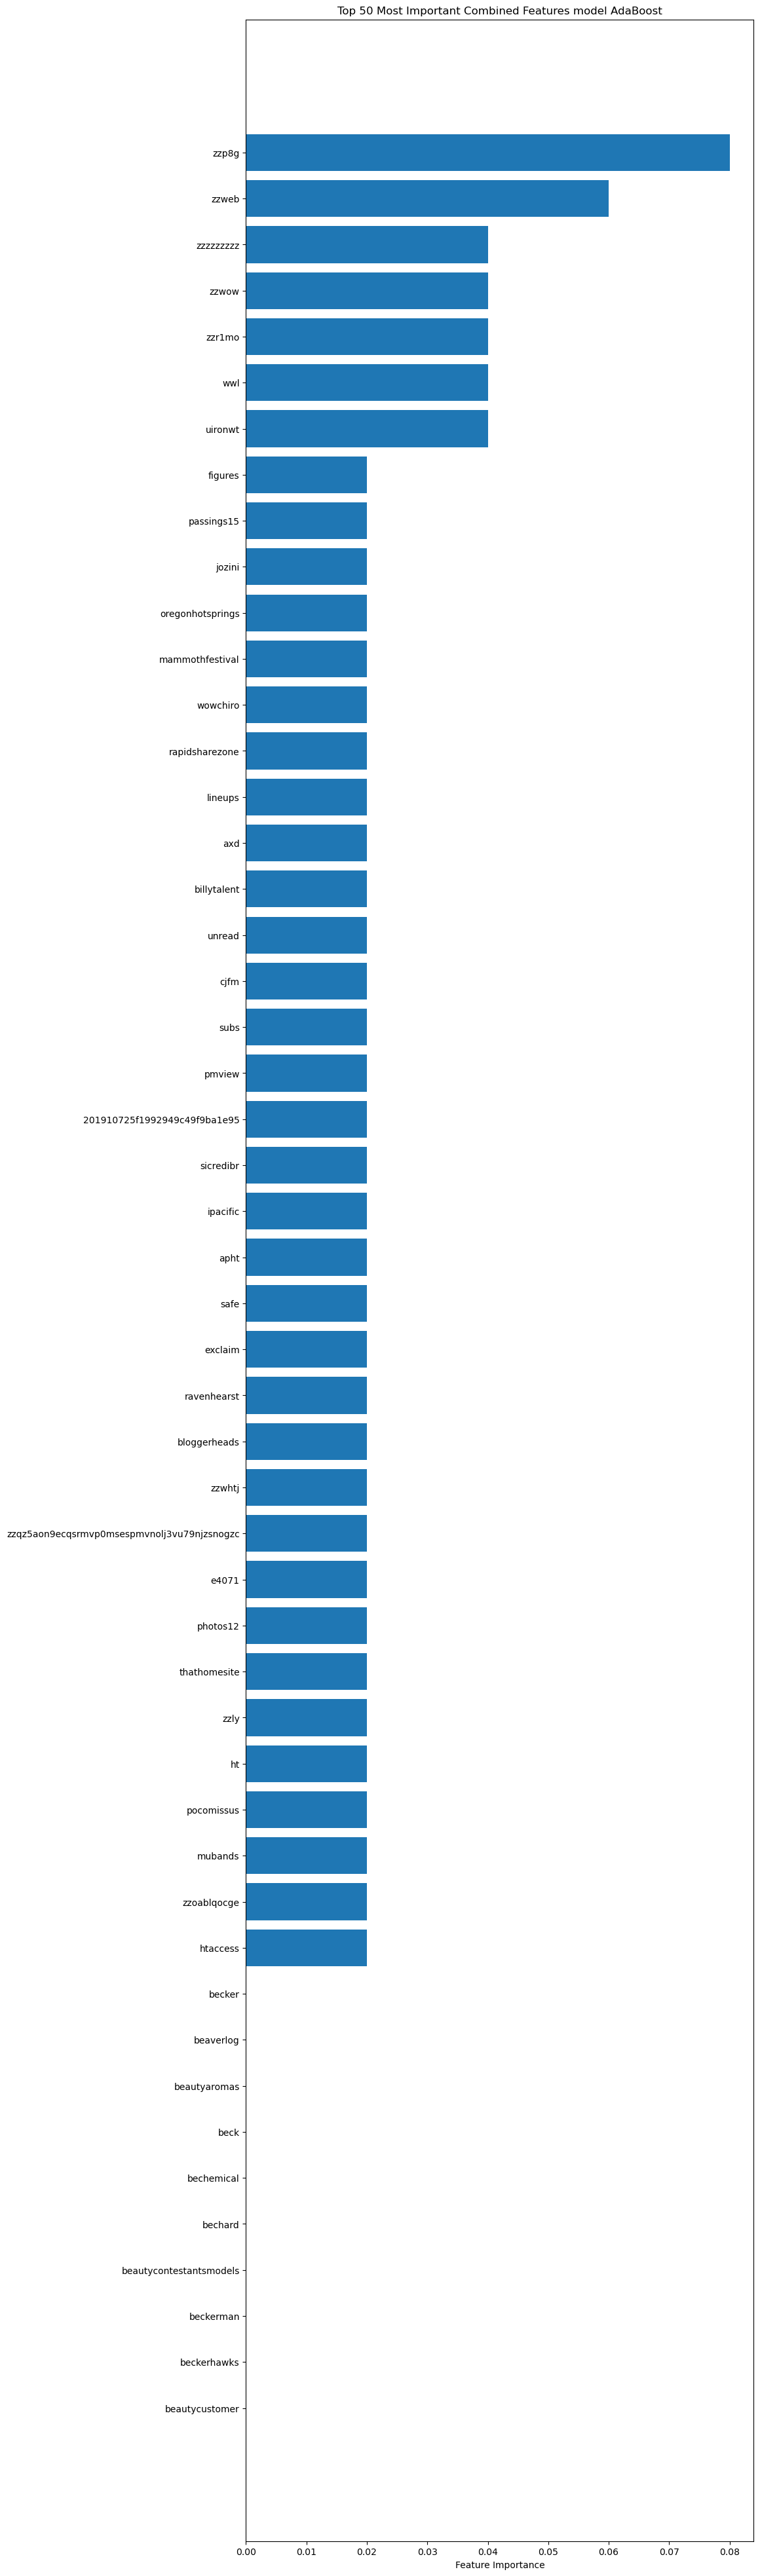

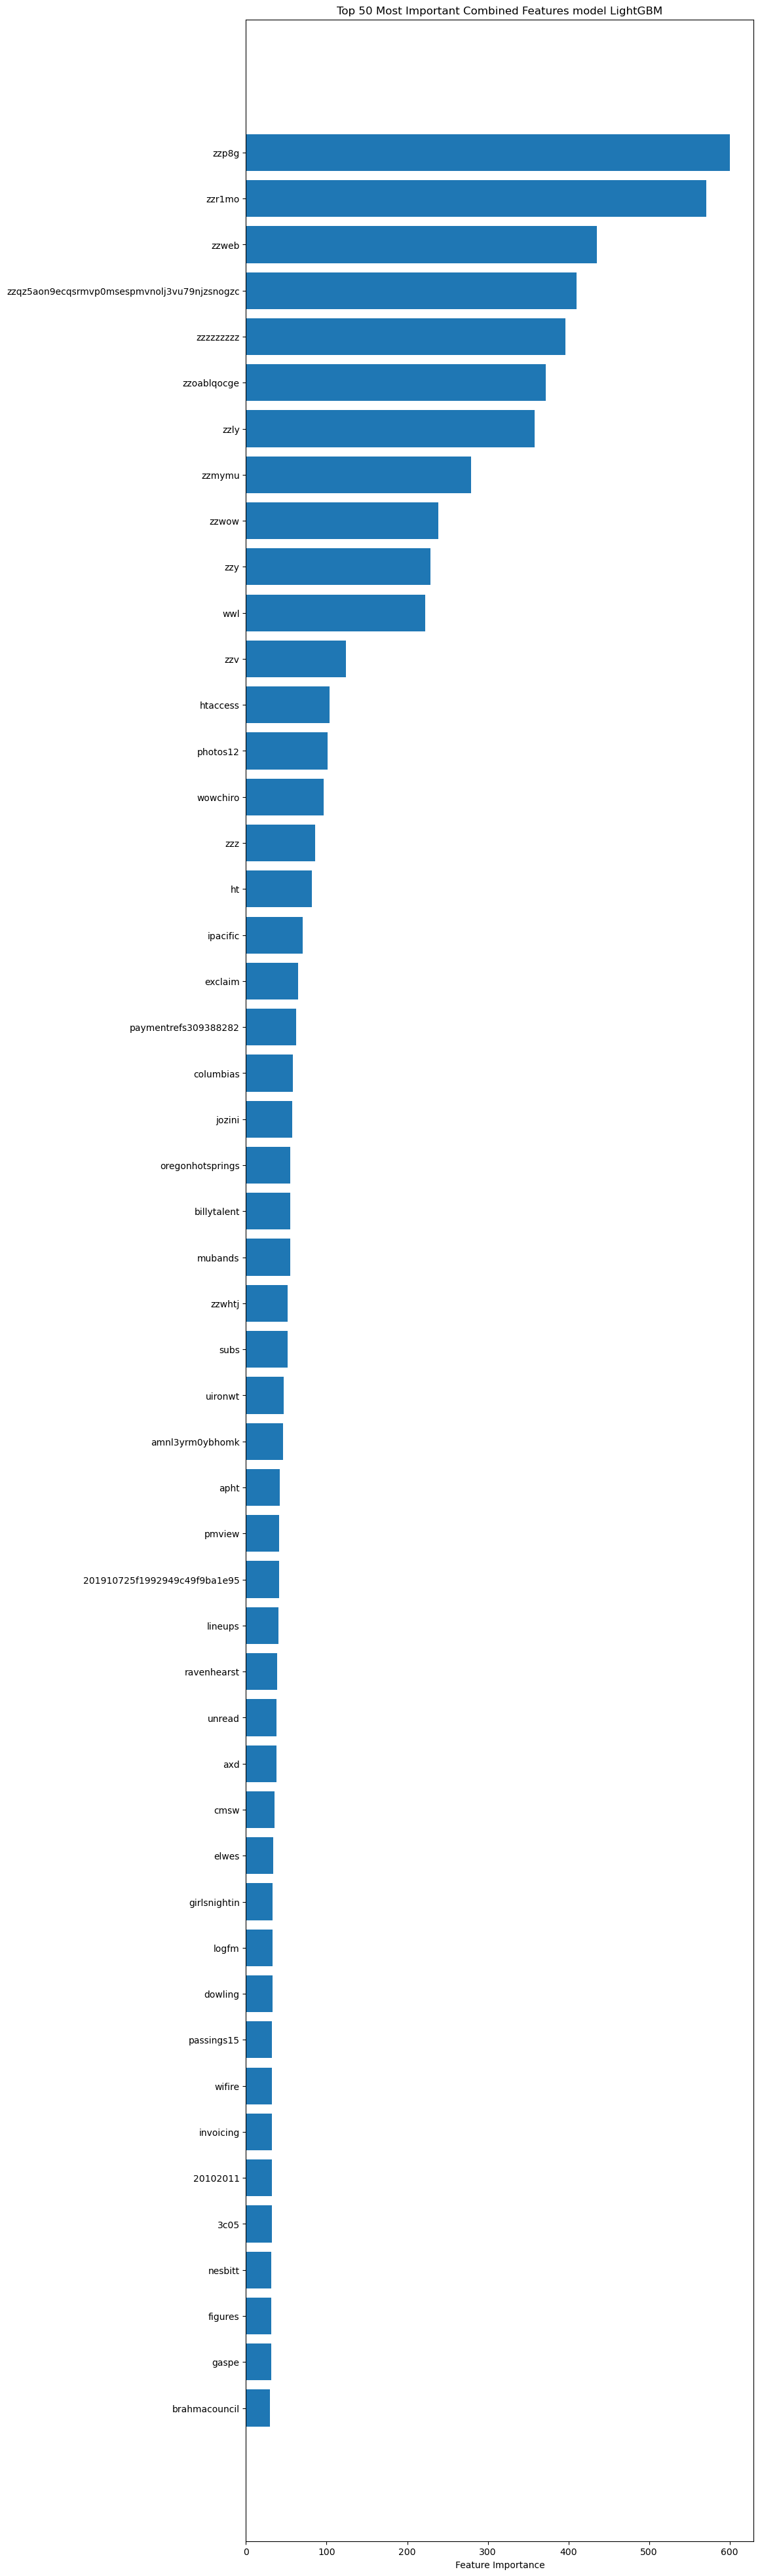

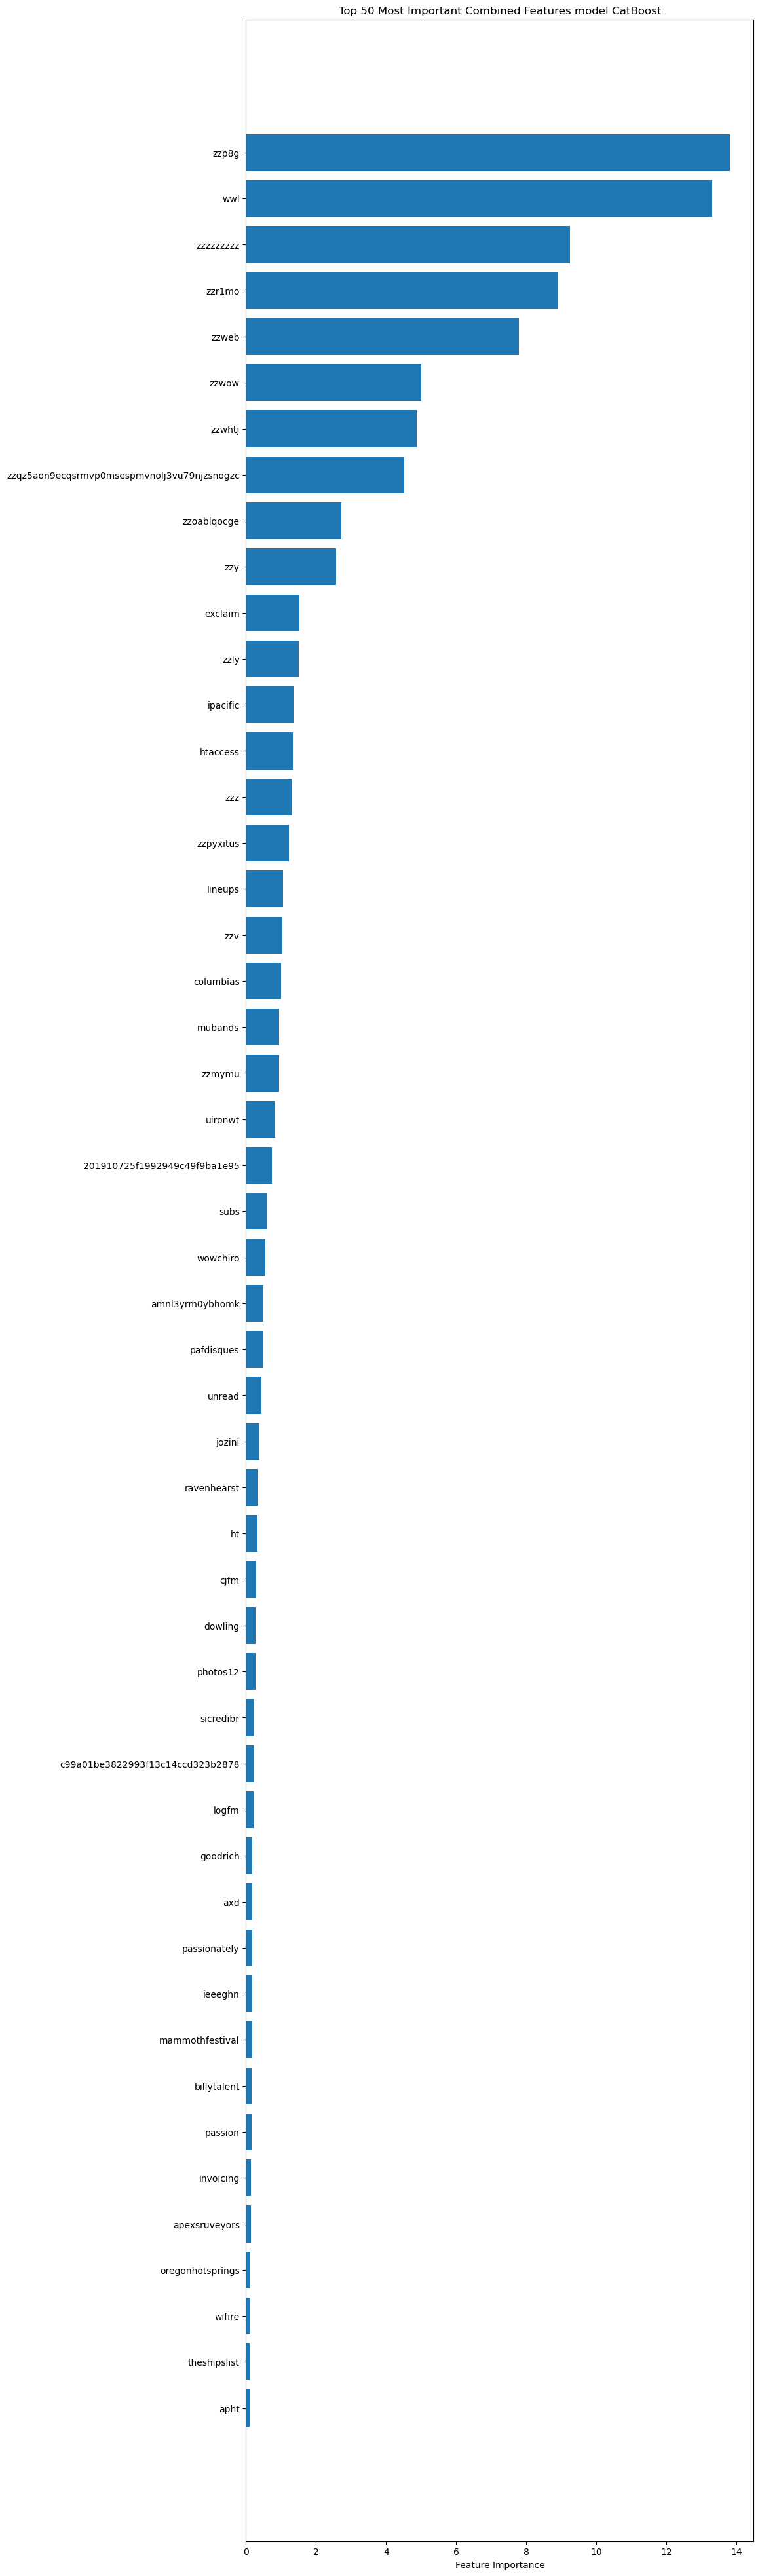

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
         'url_length', 'domain_length', 'url_kl_divergence', 'num_special_symbols', 'contains_ip',
    'domain_kl_divergence', 'path_kl_divergence', 'query_kl_divergence', 'query_path_kl_divergence', 
    'presence_of_suspicious_file_extensions', 'sub_domains_count', 'digit_frequency', 
    'count_tlds', 'is_short_url','similar_domain'
    ]

    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])

    vectorizer = CountVectorizer()
    X_Bow = vectorizer.fit_transform(text_data)
    
    X_combined = hstack((X_Bow, other_features_scaled))

    return X_combined, url_df['label'], vectorizer, numerical_features

def initialize_and_fit_models(X_train, y_train):
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    ada_clf = AdaBoostClassifier()
    lgb_clf = lgb.LGBMClassifier()
    cat_clf = CatBoostClassifier(verbose=0)

    ensemble_clf = VotingClassifier(estimators=[
        ('xgb', xgb_clf), ('ada', ada_clf), ('lgb', lgb_clf), ('cat', cat_clf)
    ], voting='soft')

    models = {'XGBoost': xgb_clf, 'AdaBoost': ada_clf, 'LightGBM': lgb_clf, 'CatBoost': cat_clf, 'Ensemble': ensemble_clf}
    for name, model in models.items():
        model.fit(X_train, y_train)

    return models

from sklearn.metrics import confusion_matrix
import numpy as np


# Enhanced function to evaluate models and plot confusion matrices with labels
def enhanced_evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        error_rate = 1 - accuracy
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'Accuracy': accuracy,
            'Error Rate': error_rate,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': fscore,
            'Confusion Matrix': cm
        }
        
        # Print results
        print(f"{name} - Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
        
        # Plotting the confusion matrix with labels
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    return results

# Visualization for overall comparison
def plot_model_comparisons(results):
    metrics = ['Accuracy', 'Error Rate', 'Precision', 'Recall', 'F1 Score']
    for metric in metrics:
        values = [results[name][metric] for name in results]
        sns.barplot(x=list(results.keys()), y=values)
        plt.title(f'Comparison of Models based on {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.show()


def plot_feature_importances(clf, vectorizer, numerical_features,model_name, top_n=50):
    tfidf_features = vectorizer.get_feature_names_out()
    all_features = numerical_features + list(tfidf_features)

    feature_importances = clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_n_indices = sorted_idx[:top_n]
    top_n_importances = feature_importances[top_n_indices]
    top_n_features = np.array(all_features)[top_n_indices]

    plt.figure(figsize=(10, top_n))
    plt.barh(range(top_n), top_n_importances, align='center')
    plt.yticks(range(top_n), top_n_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Combined Features model {model_name}')
    plt.show()

# Main workflow
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

models = initialize_and_fit_models(X_train, y_train)

model_metrics = enhanced_evaluate_models(models, X_test, y_test)

# Plot the comparison of models
plot_model_comparisons(model_metrics)

# Plot feature importance for a specific model, e.g., XGBoost
plot_feature_importances(models['XGBoost'], vectorizer, numerical_features,'XGBoost')
plot_feature_importances(models['AdaBoost'], vectorizer, numerical_features,'AdaBoost')
plot_feature_importances(models['LightGBM'], vectorizer, numerical_features,'LightGBM')
plot_feature_importances(models['CatBoost'], vectorizer, numerical_features,'CatBoost')




#  Ensemble Model - TF-IDF & DataExplorasion

Label mapping: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65803
[LightGBM] [Info] Number of data points in the train set: 85691, number of used features: 1012
[LightGBM] [Info] Start training from score -0.617681
[LightGBM] [Info] Start training from score -1.214032
[LightGBM] [Info] Start training from score -2.009445
[LightGBM] [Info] Start training from score -3.515047


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65803
[LightGBM] [Info] Number of data points in the train set: 85691, number of used features: 1012
[LightGBM] [Info] Start training from score -0.617681
[LightGBM] [Info] Start training from score -1.214032
[LightGBM] [Info] Start training from score -2.009445
[LightGBM] [Info] Start training from score -3.515047
XGBoost - Accuracy: 0.9412, Error Rate: 0.0588, Precision: 0.9296, Recall: 0.8438, F1 Score: 0.8804


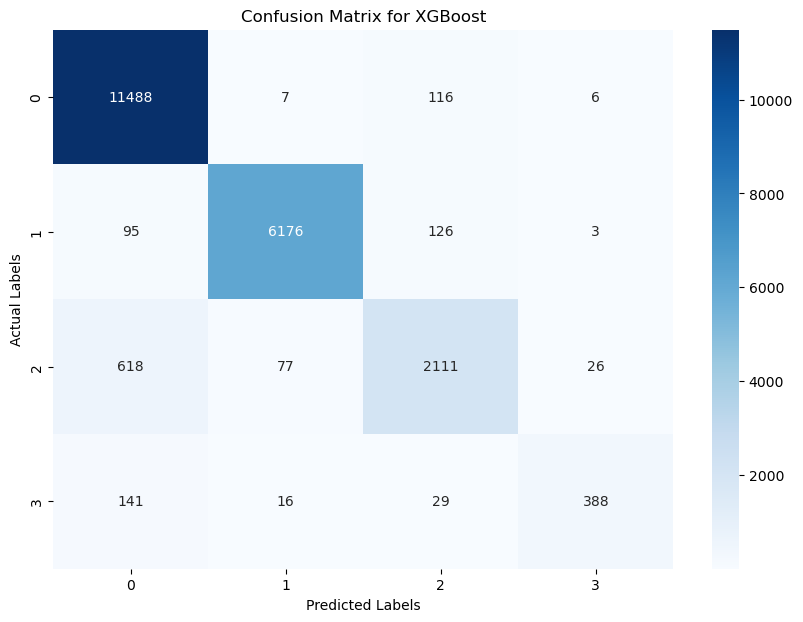

AdaBoost - Accuracy: 0.8502, Error Rate: 0.1498, Precision: 0.7990, Recall: 0.6812, F1 Score: 0.7187


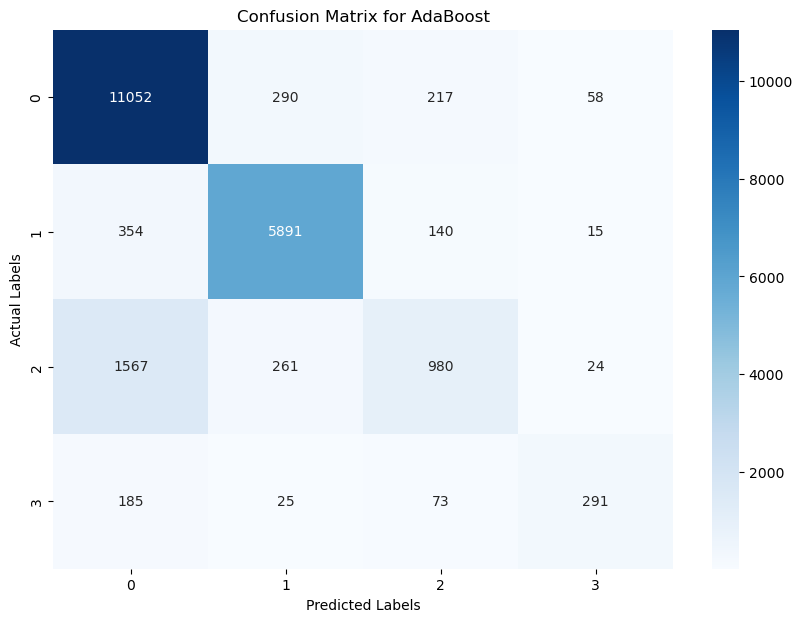

LightGBM - Accuracy: 0.9451, Error Rate: 0.0549, Precision: 0.9284, Recall: 0.8582, F1 Score: 0.8891


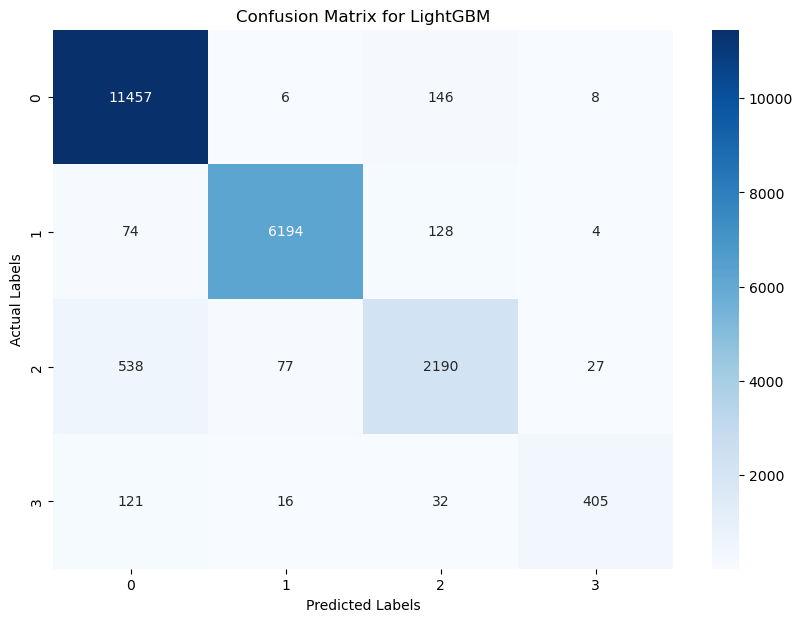

CatBoost - Accuracy: 0.9375, Error Rate: 0.0625, Precision: 0.9286, Recall: 0.8332, F1 Score: 0.8724


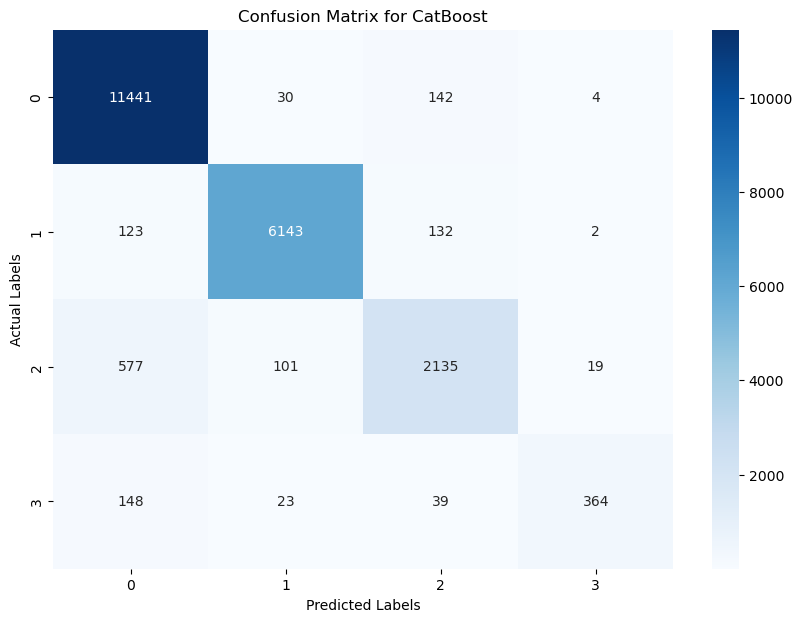

Ensemble - Accuracy: 0.9427, Error Rate: 0.0573, Precision: 0.9323, Recall: 0.8443, F1 Score: 0.8814


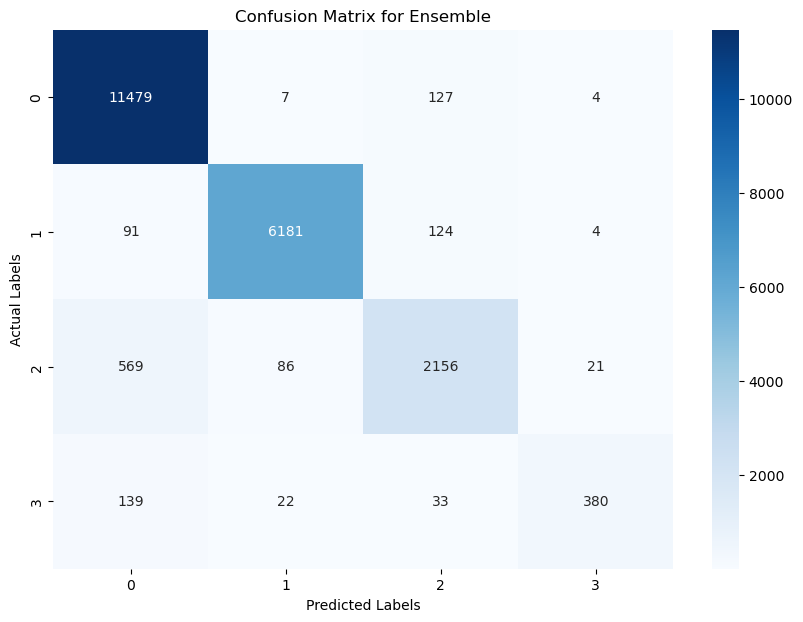

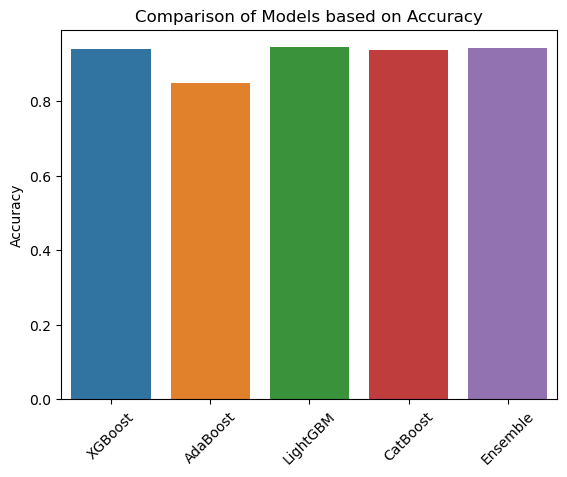

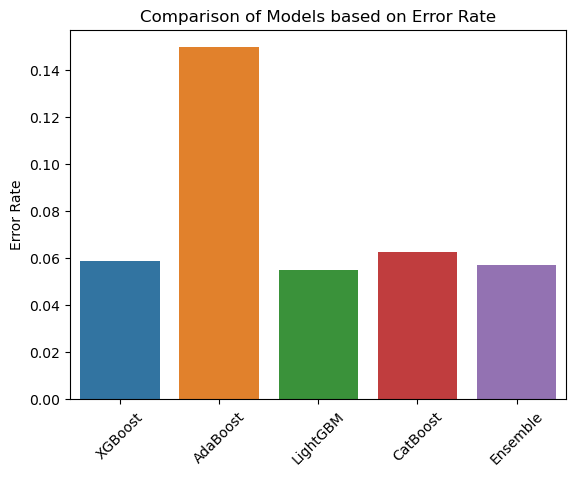

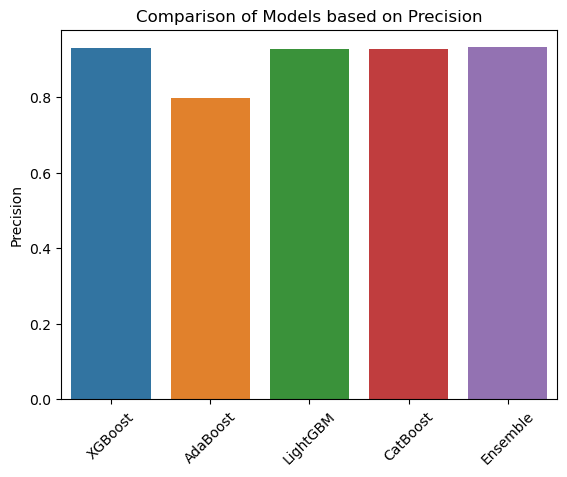

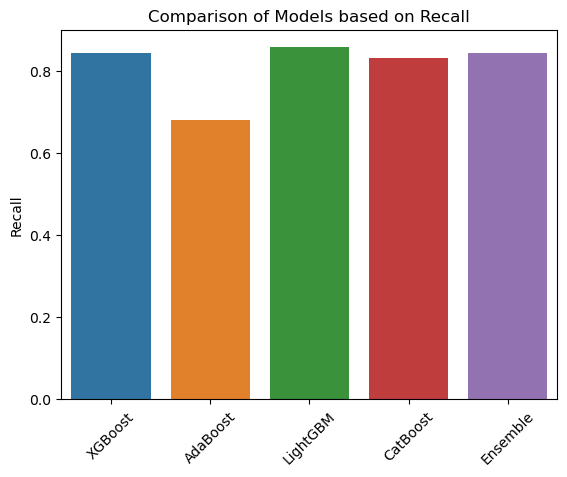

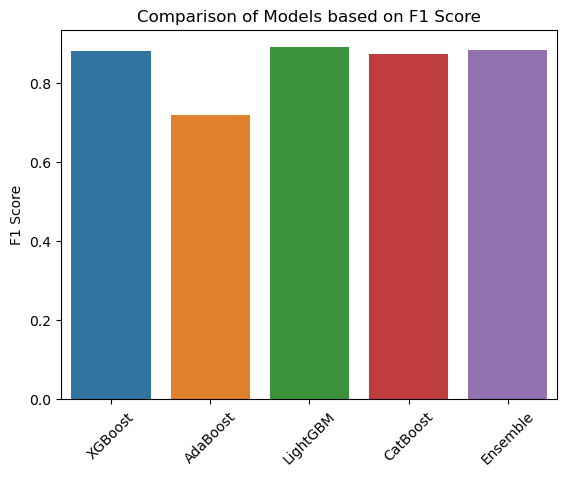

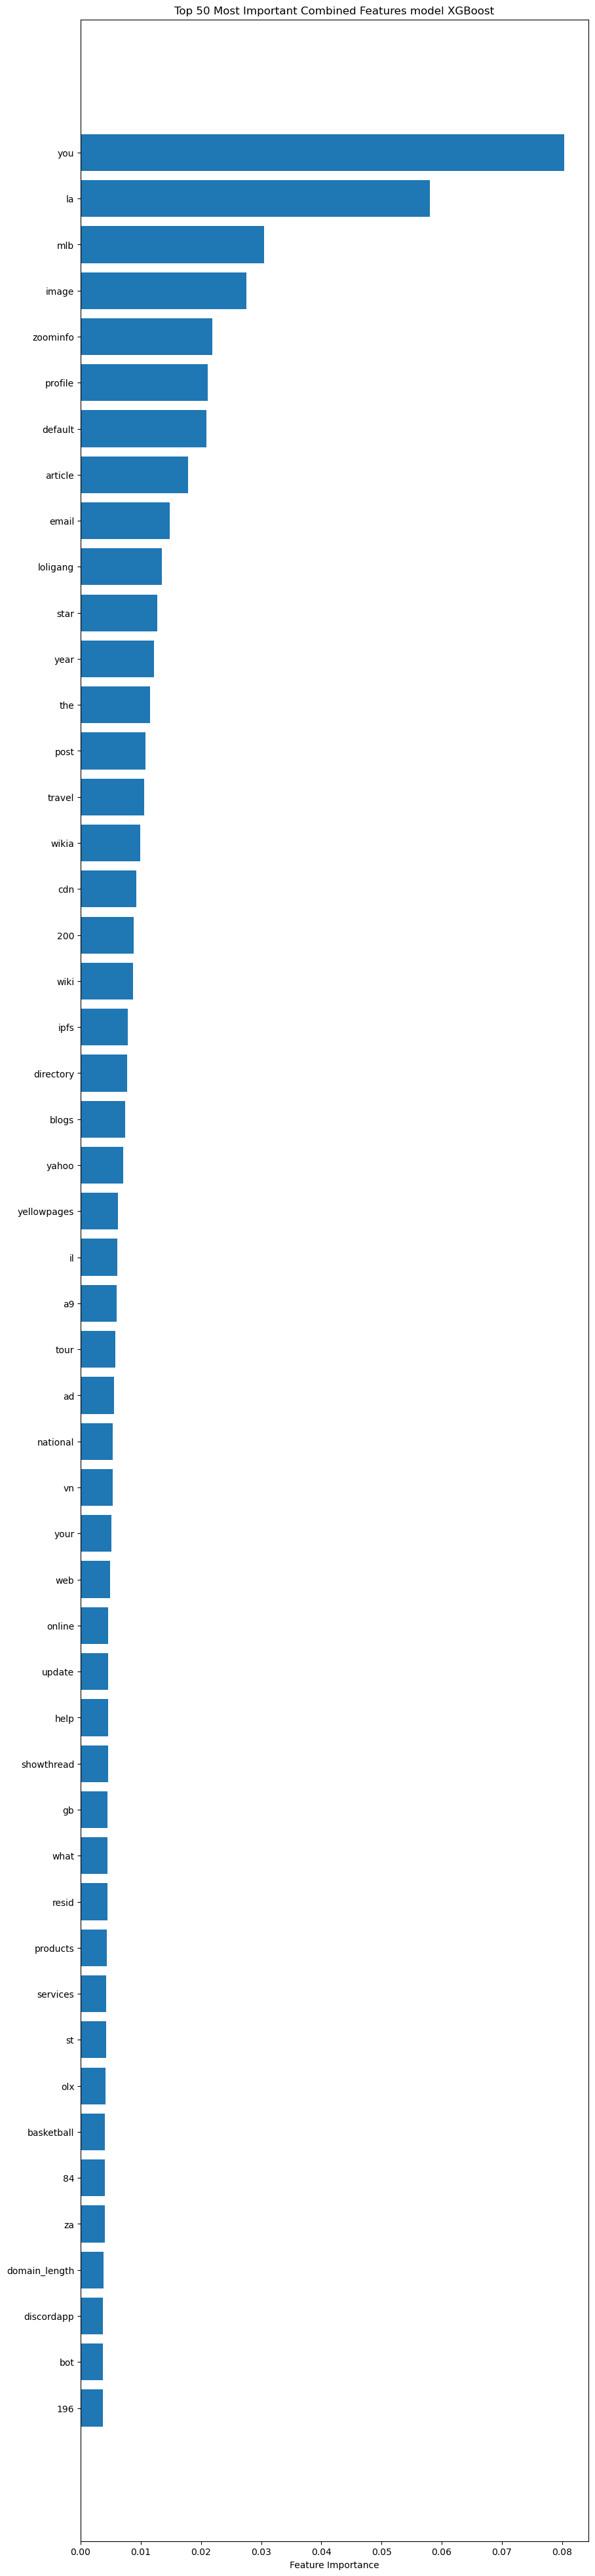

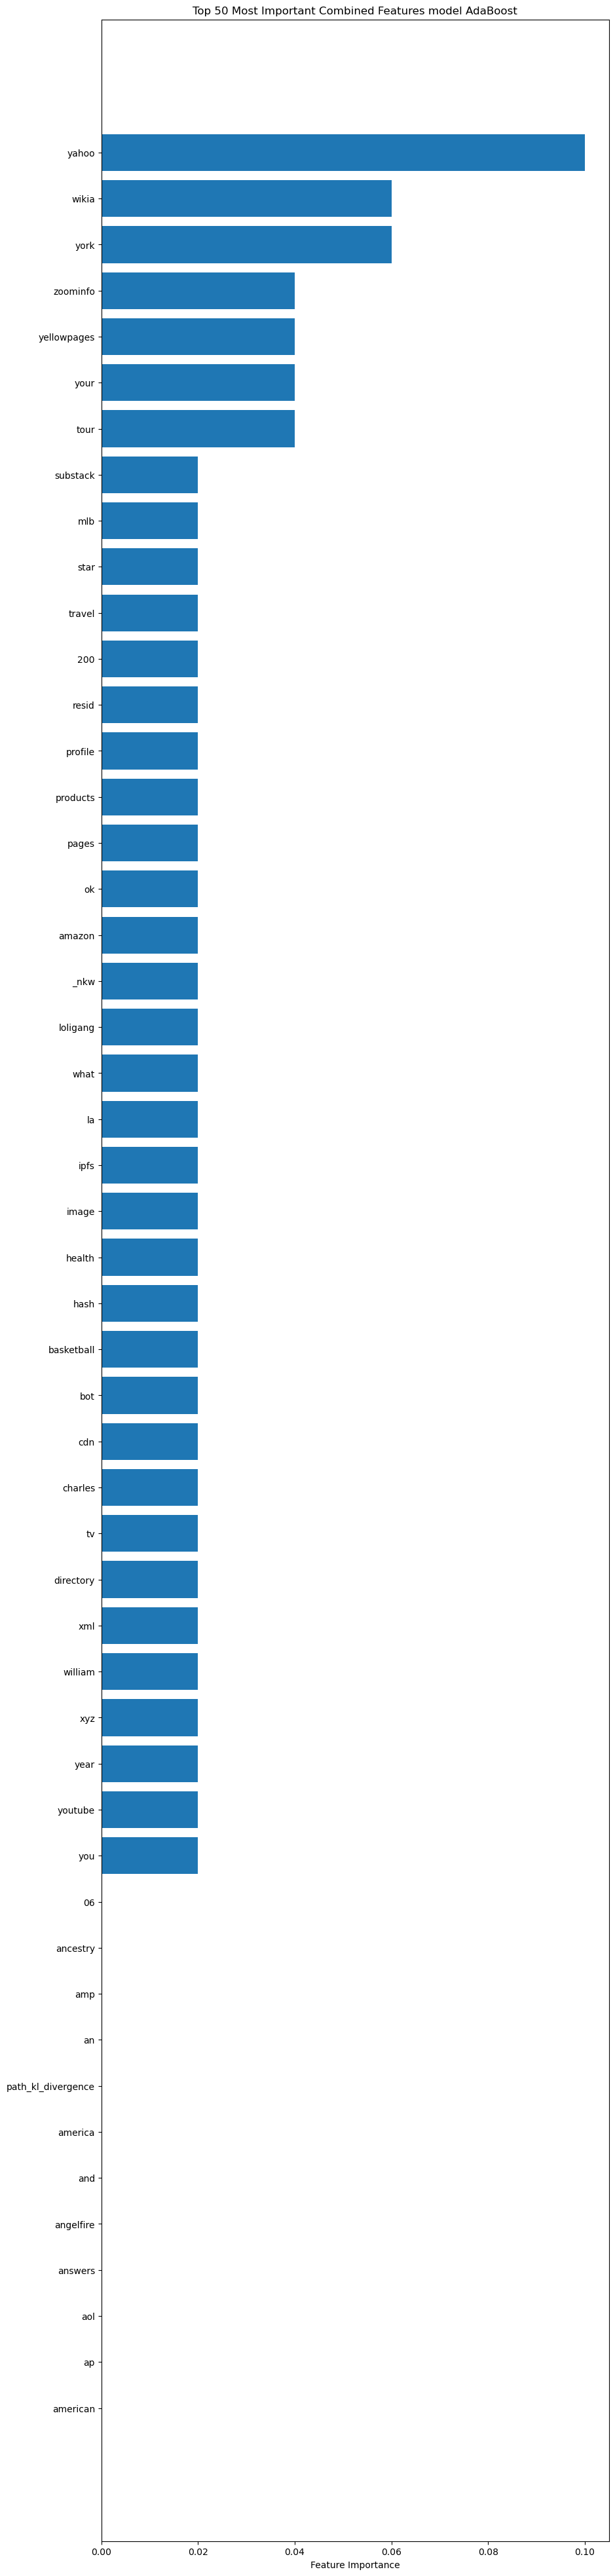

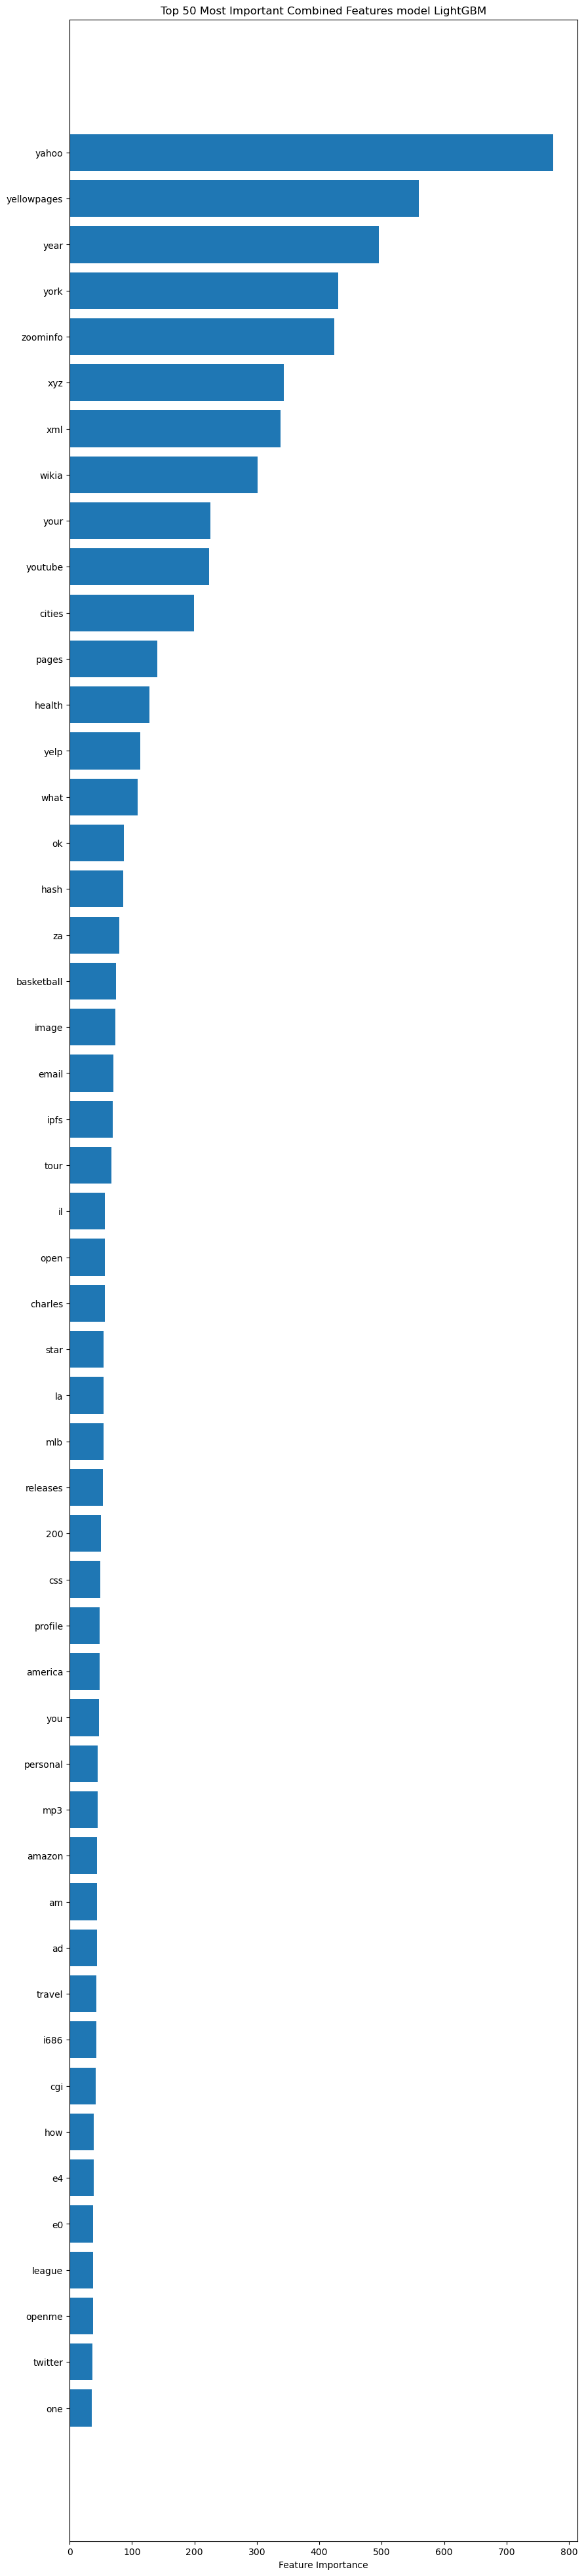

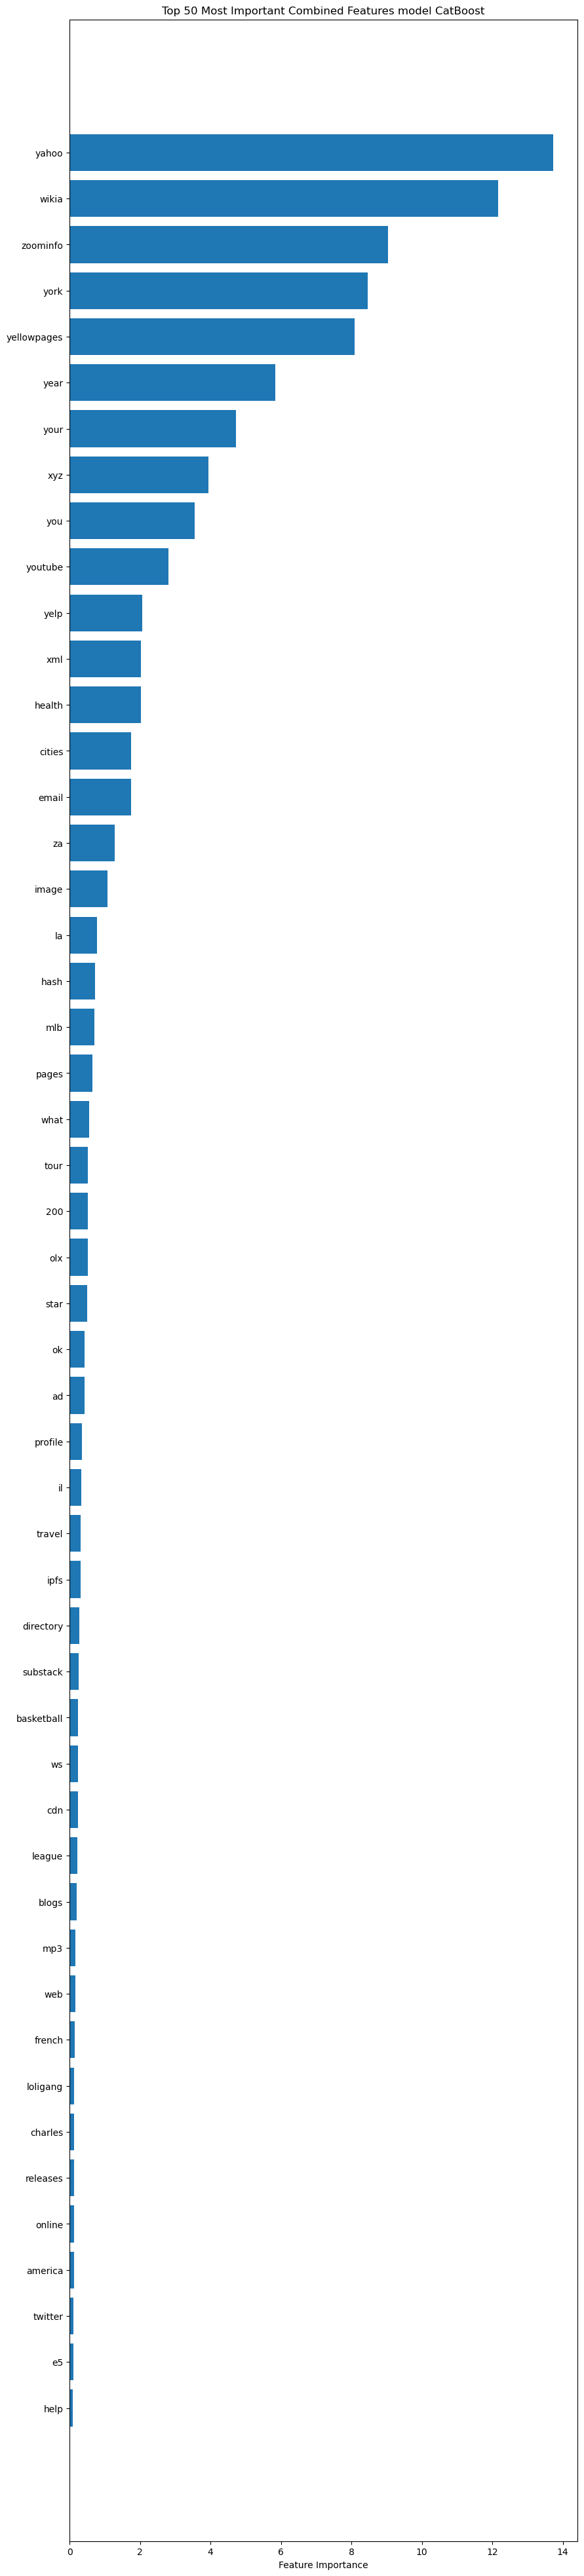

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.sparse import csr_matrix


def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
                'domain_length', 'url_kl_divergence', 'num_special_symbols', 
    'domain_kl_divergence', 'path_kl_divergence', 'query_kl_divergence', 'query_path_kl_divergence', 
    'presence_of_suspicious_file_extensions', 'sub_domains_count', 'digit_frequency', 
    'count_tlds', 'is_short_url','similar_domain'
    ]
    
    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])
    
    vectorizer = TfidfVectorizer(max_features=1000)  
    X_tfidf = vectorizer.fit_transform(text_data)
      

    X_combined = hstack((X_tfidf, other_features_scaled))

    return X_combined, url_df['label'], vectorizer, numerical_features

def initialize_and_fit_models(X_train, y_train):
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    ada_clf = AdaBoostClassifier()
    lgb_clf = lgb.LGBMClassifier()
    cat_clf = CatBoostClassifier(verbose=0)

    ensemble_clf = VotingClassifier(estimators=[
        ('xgb', xgb_clf), ('ada', ada_clf), ('lgb', lgb_clf), ('cat', cat_clf)
    ], voting='soft')

    models = {'XGBoost': xgb_clf, 'AdaBoost': ada_clf, 'LightGBM': lgb_clf, 'CatBoost': cat_clf, 'Ensemble': ensemble_clf}
    for name, model in models.items():
        model.fit(X_train, y_train)

    return models

from sklearn.metrics import confusion_matrix
import numpy as np


# Enhanced function to evaluate models and plot confusion matrices with labels
def enhanced_evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        error_rate = 1 - accuracy
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'Accuracy': accuracy,
            'Error Rate': error_rate,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': fscore,
            'Confusion Matrix': cm
        }
        
        # Print results
        print(f"{name} - Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
        
        # Plotting the confusion matrix with labels
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('Actual Labels')
        plt.show()
    
    return results

# Visualization for overall comparison
def plot_model_comparisons(results):
    metrics = ['Accuracy', 'Error Rate', 'Precision', 'Recall', 'F1 Score']
    for metric in metrics:
        values = [results[name][metric] for name in results]
        sns.barplot(x=list(results.keys()), y=values)
        plt.title(f'Comparison of Models based on {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.show()

def plot_feature_importances(clf, vectorizer, numerical_features,model_name, top_n=50):
    tfidf_features = vectorizer.get_feature_names_out()
    all_features = numerical_features + list(tfidf_features)

    feature_importances = clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_n_indices = sorted_idx[:top_n]
    top_n_importances = feature_importances[top_n_indices]
    top_n_features = np.array(all_features)[top_n_indices]

    plt.figure(figsize=(10, top_n))
    plt.barh(range(top_n), top_n_importances, align='center')
    plt.yticks(range(top_n), top_n_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Combined Features model {model_name}')
    plt.show()

# Main workflow
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

models = initialize_and_fit_models(X_train, y_train)

model_metrics = enhanced_evaluate_models(models, X_test, y_test)
plot_model_comparisons(model_metrics)
# Plot feature importance for a specific model, e.g., XGBoost
plot_feature_importances(models['XGBoost'], vectorizer, numerical_features,'XGBoost')
plot_feature_importances(models['AdaBoost'], vectorizer, numerical_features,'AdaBoost')
plot_feature_importances(models['LightGBM'], vectorizer, numerical_features,'LightGBM')
plot_feature_importances(models['CatBoost'], vectorizer, numerical_features,'CatBoost')




#  RandomForest Model -  TF-IDF and DataExplorasion

Label mapping: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}
 Random Forest - Accuracy: 0.9498, Error Rate: 0.0502, Precision: 0.9371, Recall: 0.8606, F1 Score: 0.8938


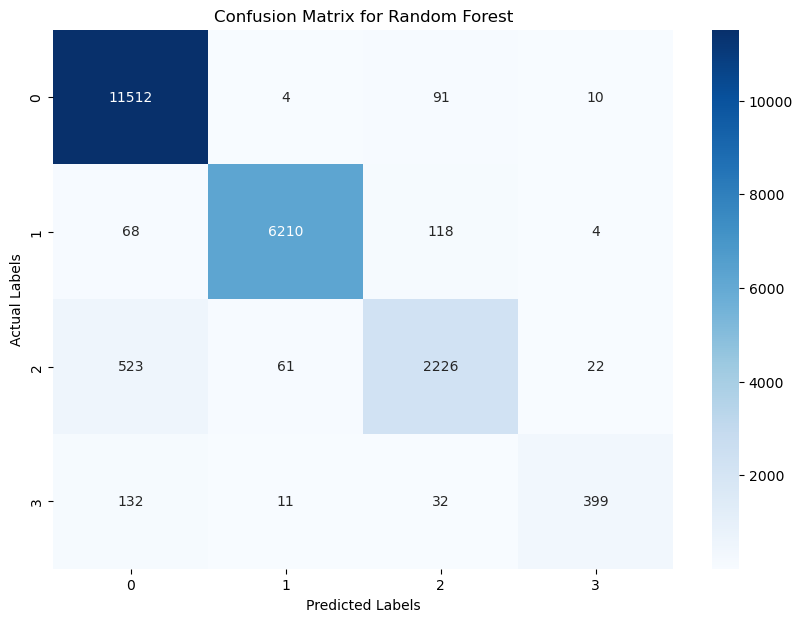

['tfidf_vectorizer.joblib']

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)
    
    joblib.dump(label_encoder, 'label_encoder.joblib')

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
           'domain_length', 'url_kl_divergence', 'num_special_symbols', 
    'domain_kl_divergence', 'path_kl_divergence', 'query_kl_divergence', 'query_path_kl_divergence', 
    'presence_of_suspicious_file_extensions', 'sub_domains_count', 'digit_frequency', 
    'count_tlds', 'is_short_url','similar_domain'
    ]
    
    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])
    
    vectorizer = TfidfVectorizer(max_features=1000)  
    X_tfidf = vectorizer.fit_transform(text_data)

    X_combined = hstack((X_tfidf, other_features_scaled))
    
    # Save the StandardScaler
    joblib.dump(scaler, 'scaler.joblib')

    return X_combined, url_df['label'], vectorizer, numerical_features

def train_random_forest(X_train, y_train):
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train, y_train)
    return rf_clf

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    
    # Print results
    print(f" Random Forest - Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
    
    # Plotting the confusion matrix with labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for Random Forest')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()
    

# Main workflow
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model = train_random_forest(X_train, y_train)
evaluate_model(model, X_test, y_test)

joblib.dump(model, 'random_forest_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')



# Step-by-Step Research implementation Ensemble Model, Omitting Spam Classification


Label mapping before filtering: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}
Label mapping after filtering: {0: 0, 1: 1, 2: 2}


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8513
[LightGBM] [Info] Number of data points in the train set: 83192, number of used features: 2460
[LightGBM] [Info] Start training from score -0.590056
[LightGBM] [Info] Start training from score -1.179458
[LightGBM] [Info] Start training from score -1.978630


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.701584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8513
[LightGBM] [Info] Number of data points in the train set: 83192, number of used features: 2460
[LightGBM] [Info] Start training from score -0.590056
[LightGBM] [Info] Start training from score -1.179458
[LightGBM] [Info] Start training from score -1.978630
XGBoost - Accuracy: 0.9523, Error Rate: 0.0477, Precision: 0.9428, Recall: 0.9094, F1 Score: 0.9245


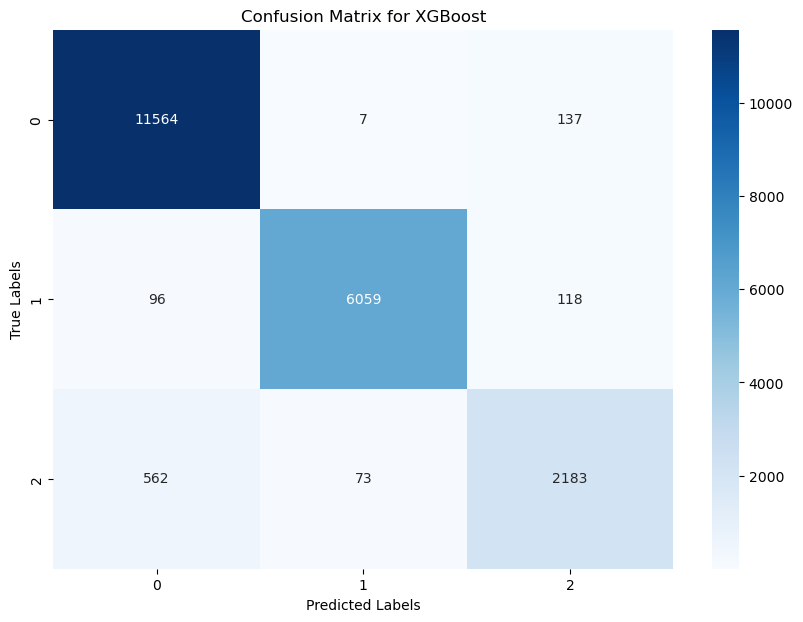

AdaBoost - Accuracy: 0.8725, Error Rate: 0.1275, Precision: 0.8309, Recall: 0.7662, F1 Score: 0.7877


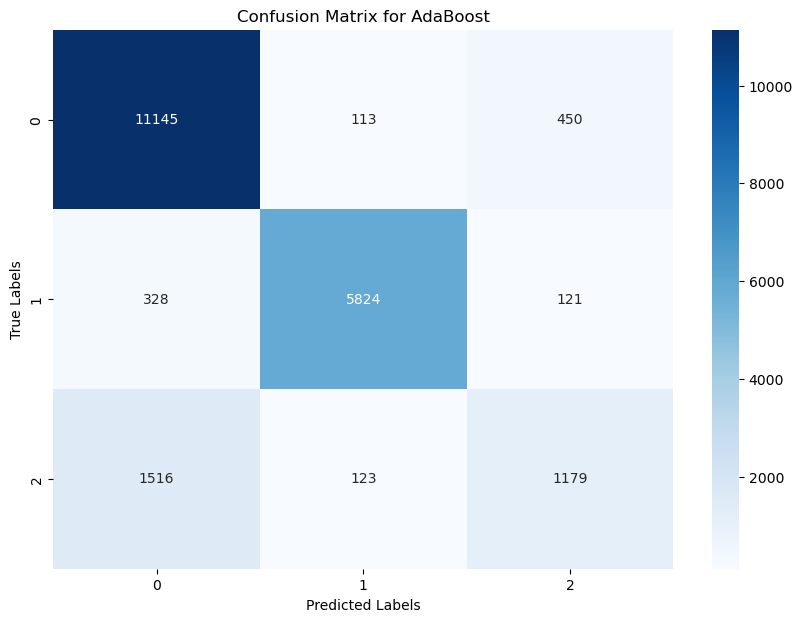

LightGBM - Accuracy: 0.9550, Error Rate: 0.0450, Precision: 0.9442, Recall: 0.9161, F1 Score: 0.9290


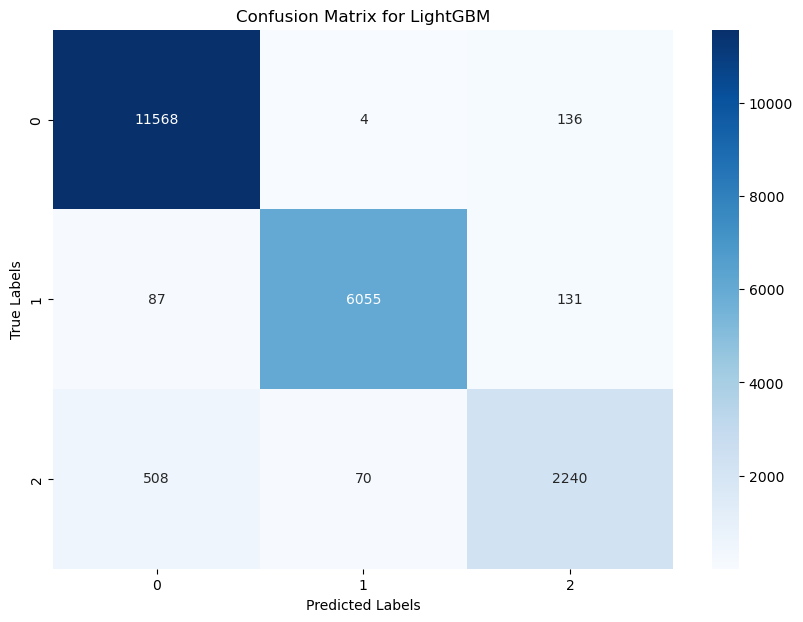

CatBoost - Accuracy: 0.9422, Error Rate: 0.0578, Precision: 0.9333, Recall: 0.8897, F1 Score: 0.9086


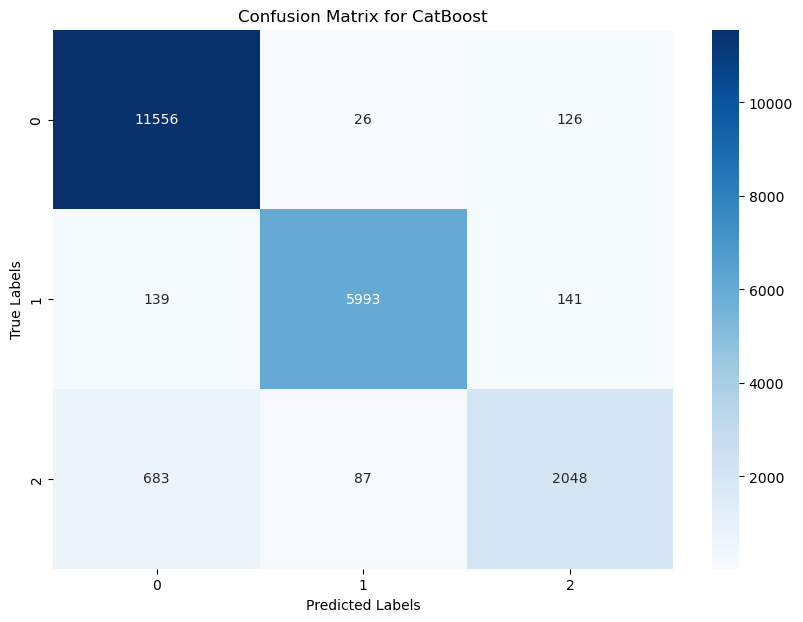

Ensemble - Accuracy: 0.9526, Error Rate: 0.0474, Precision: 0.9442, Recall: 0.9091, F1 Score: 0.9249


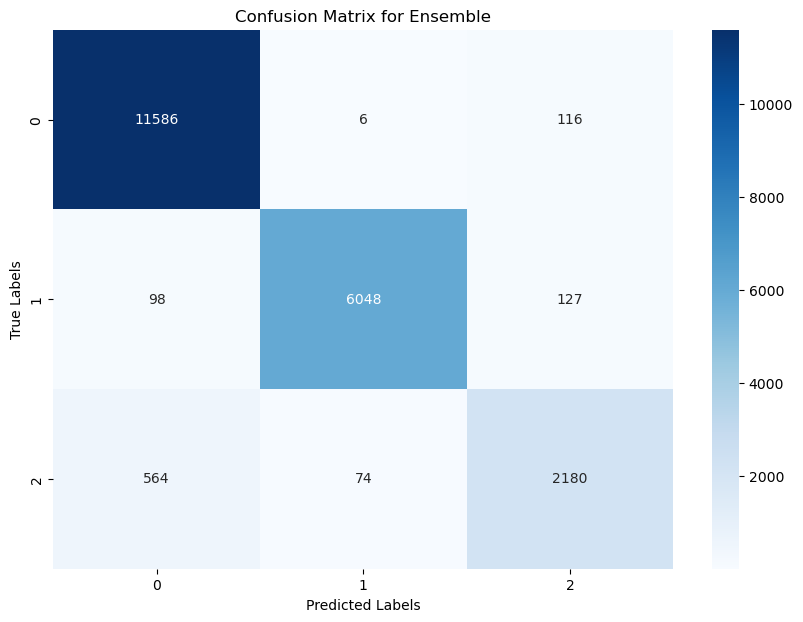

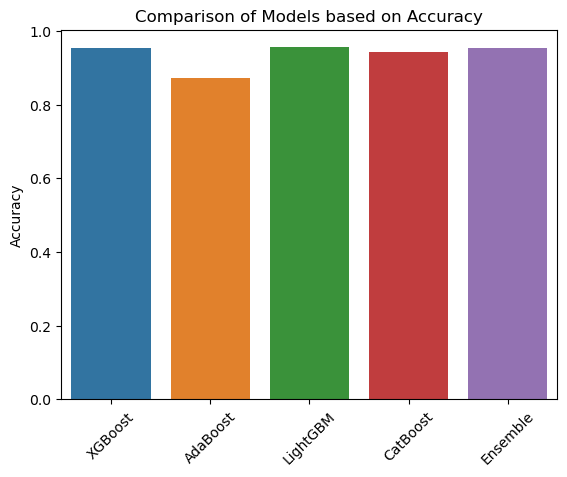

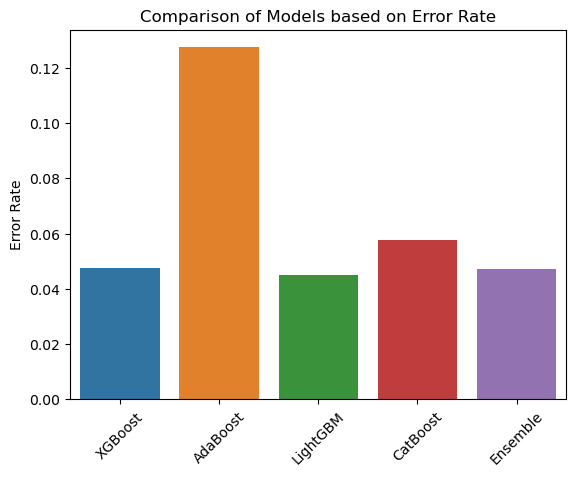

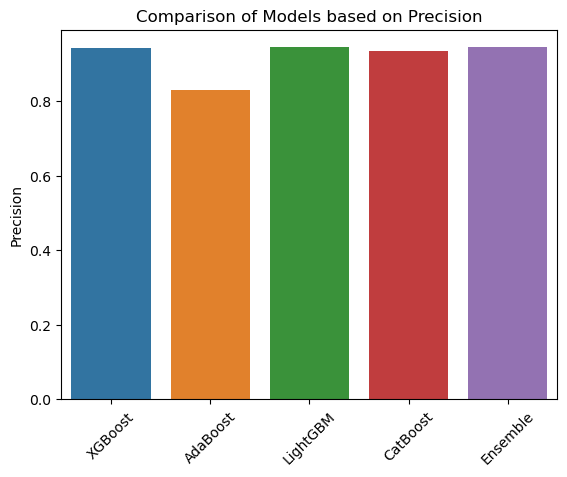

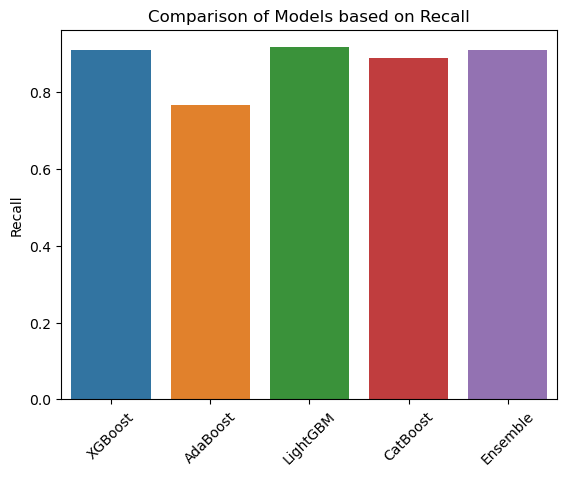

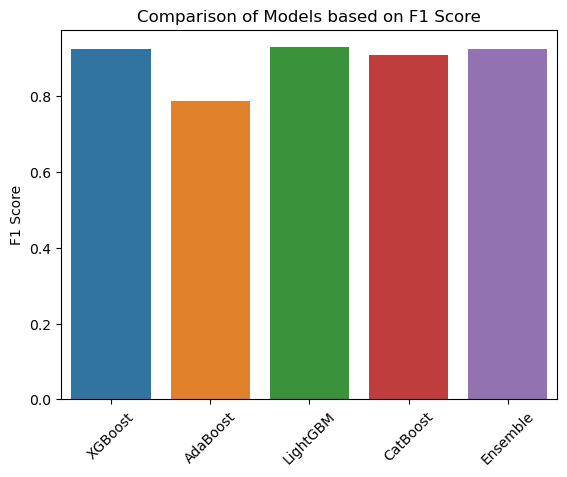

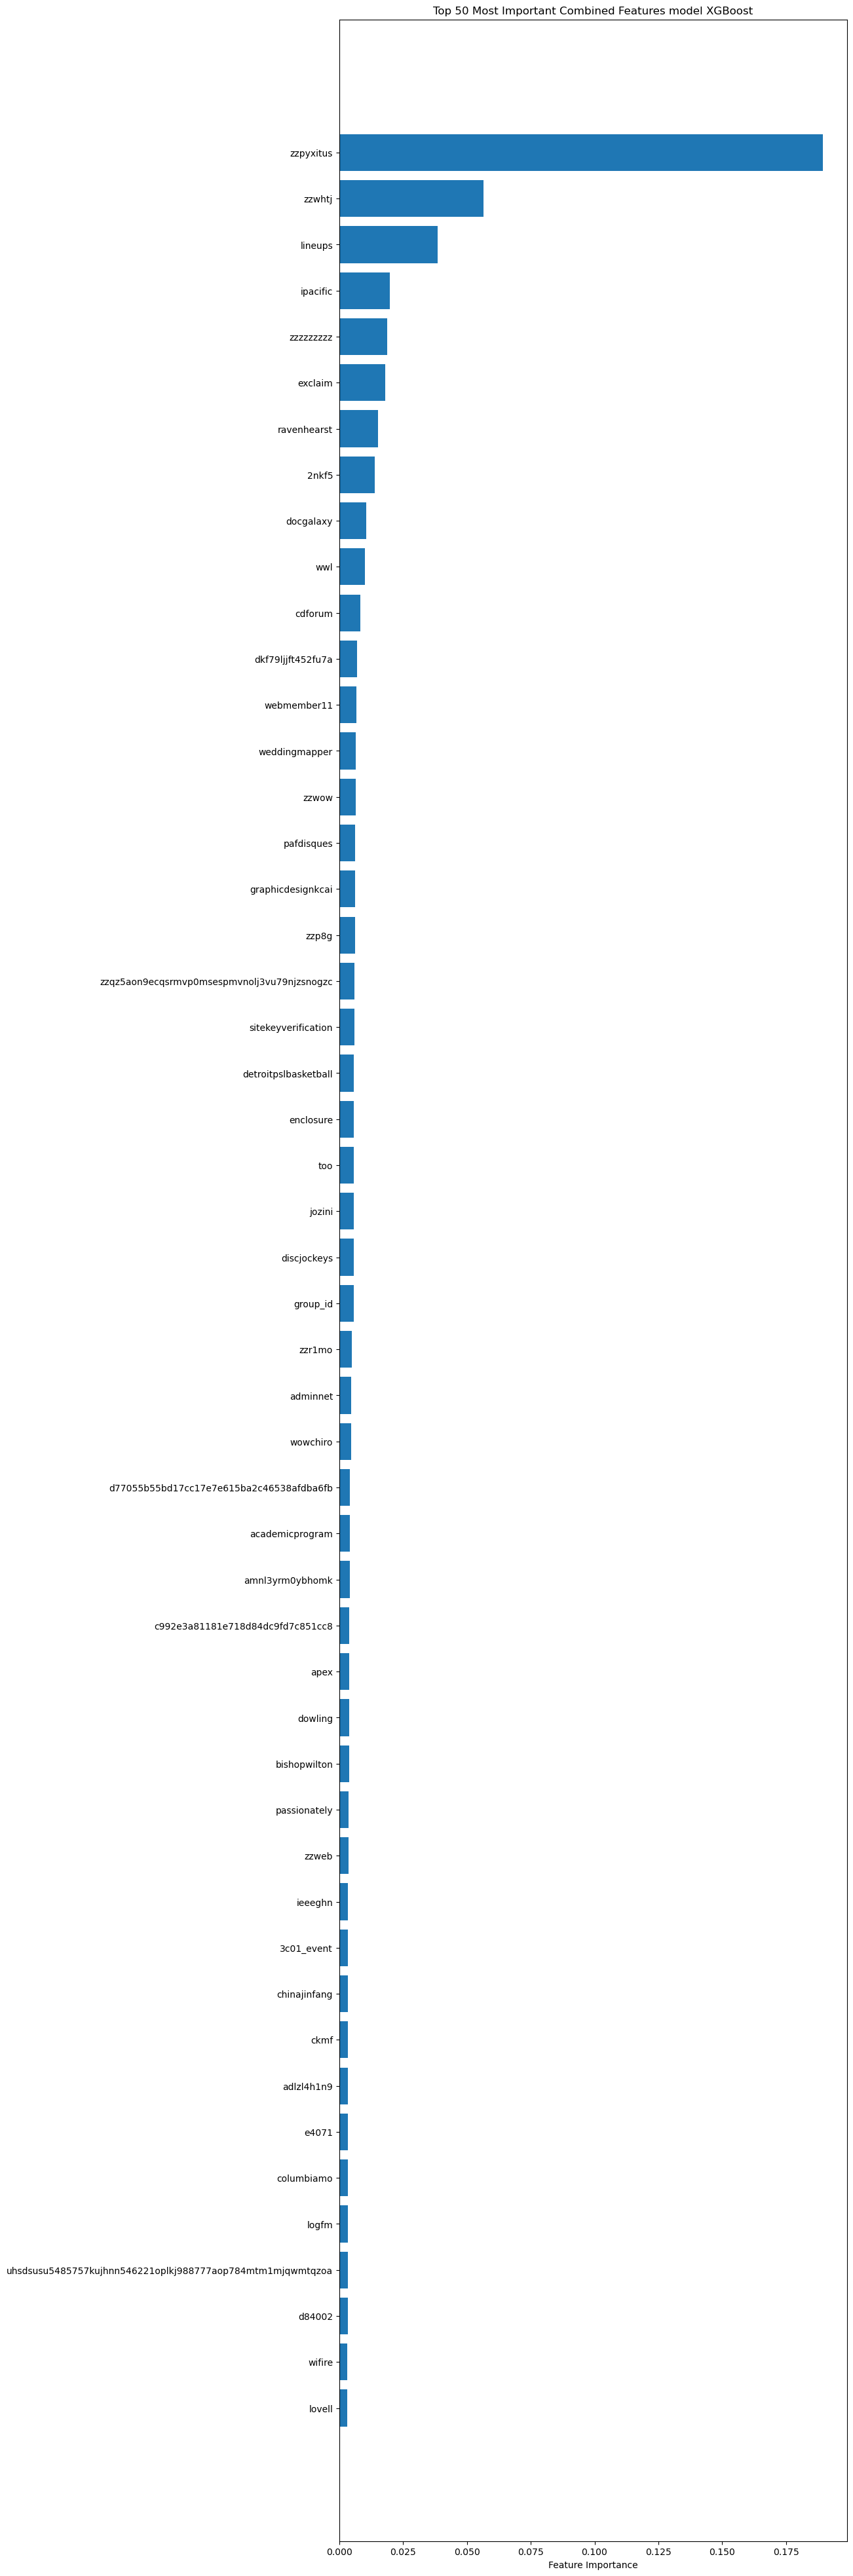

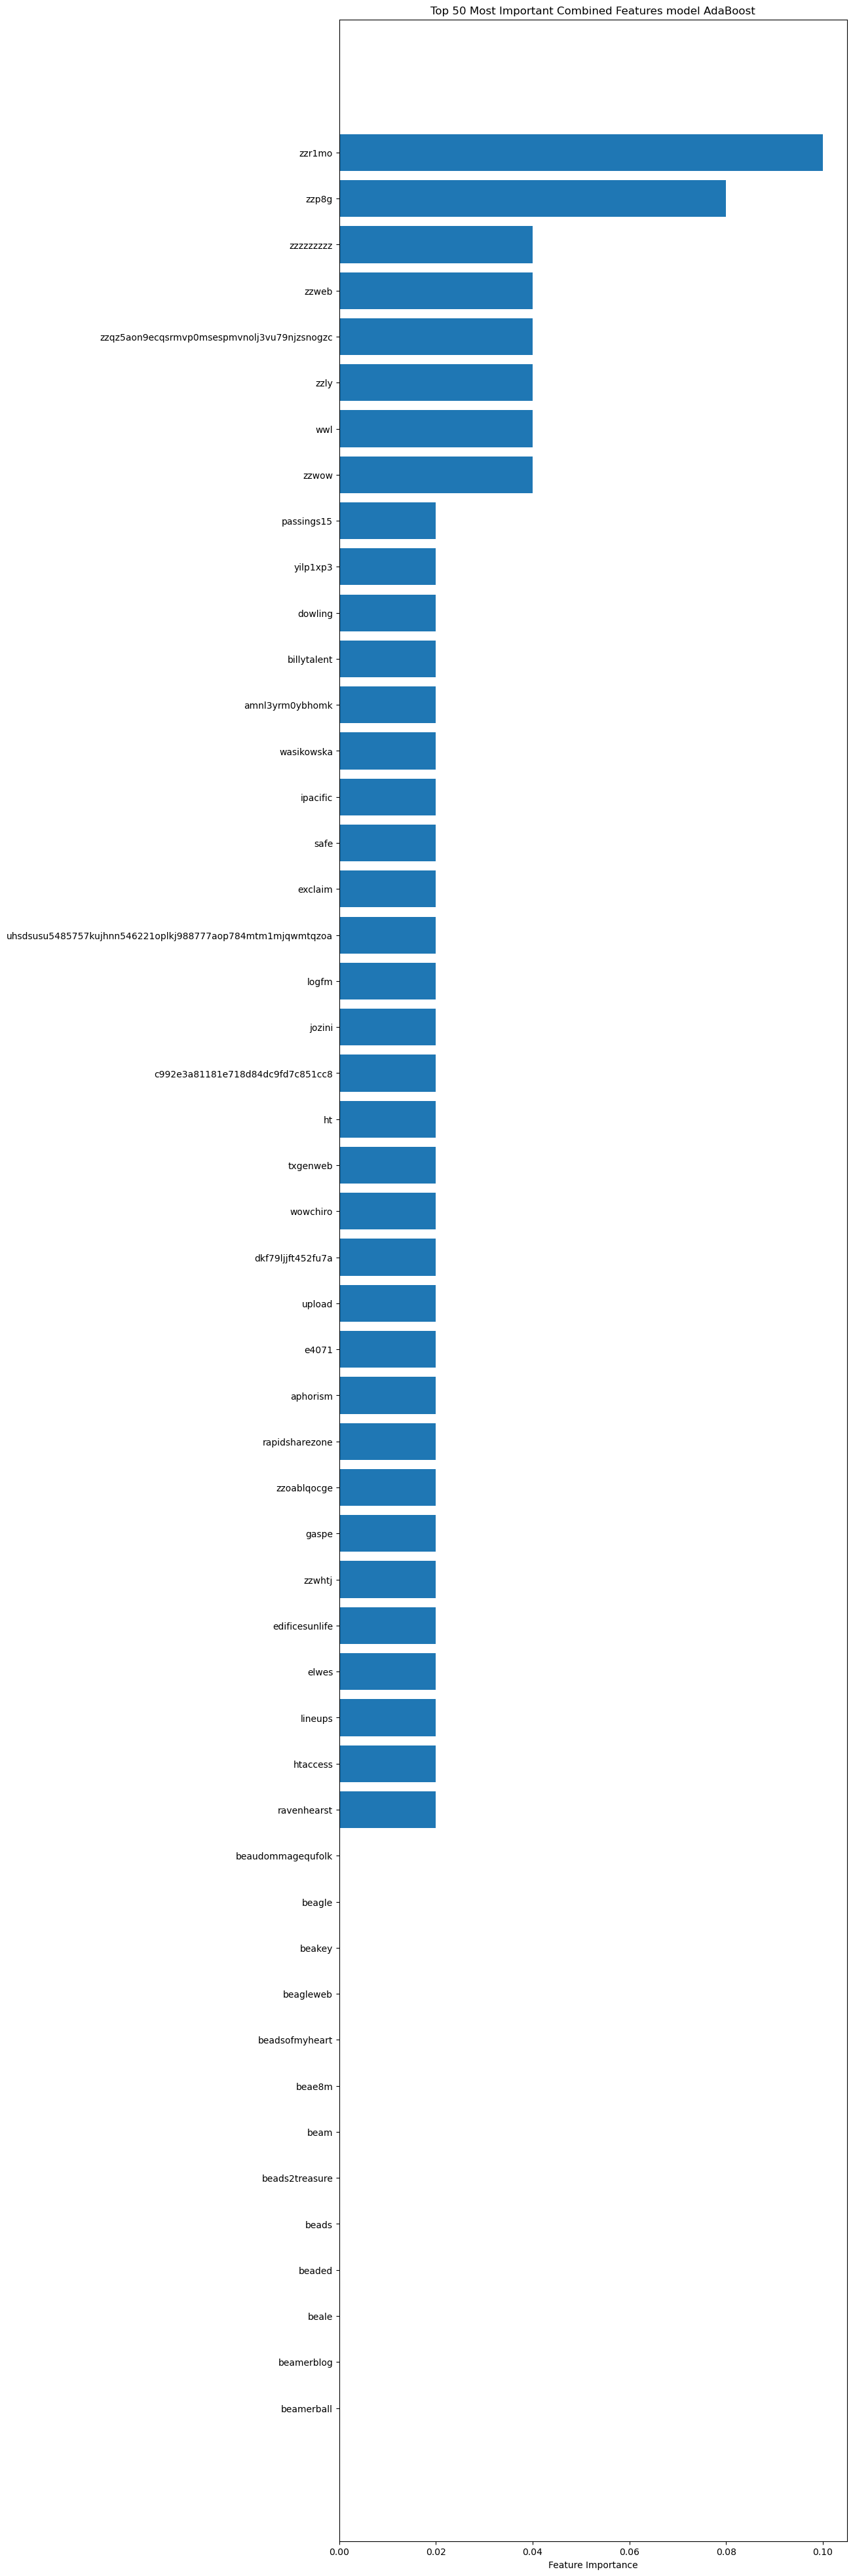

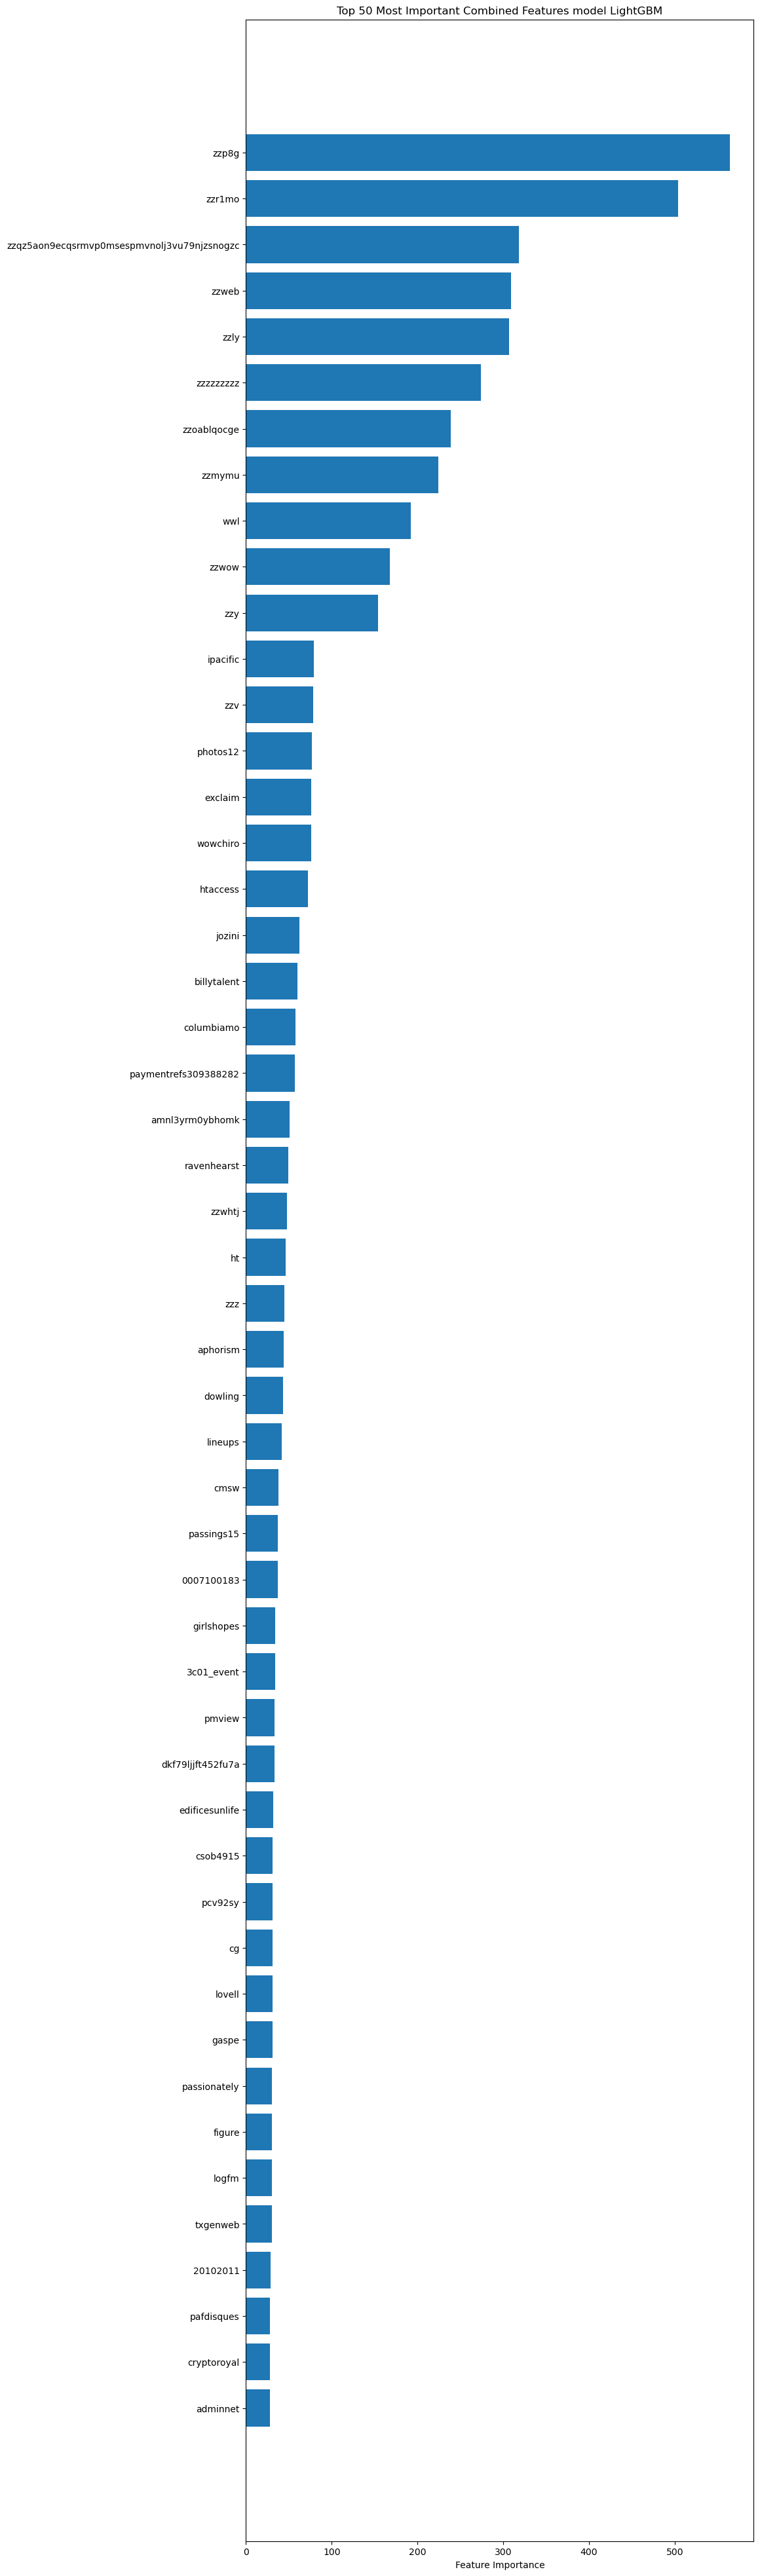

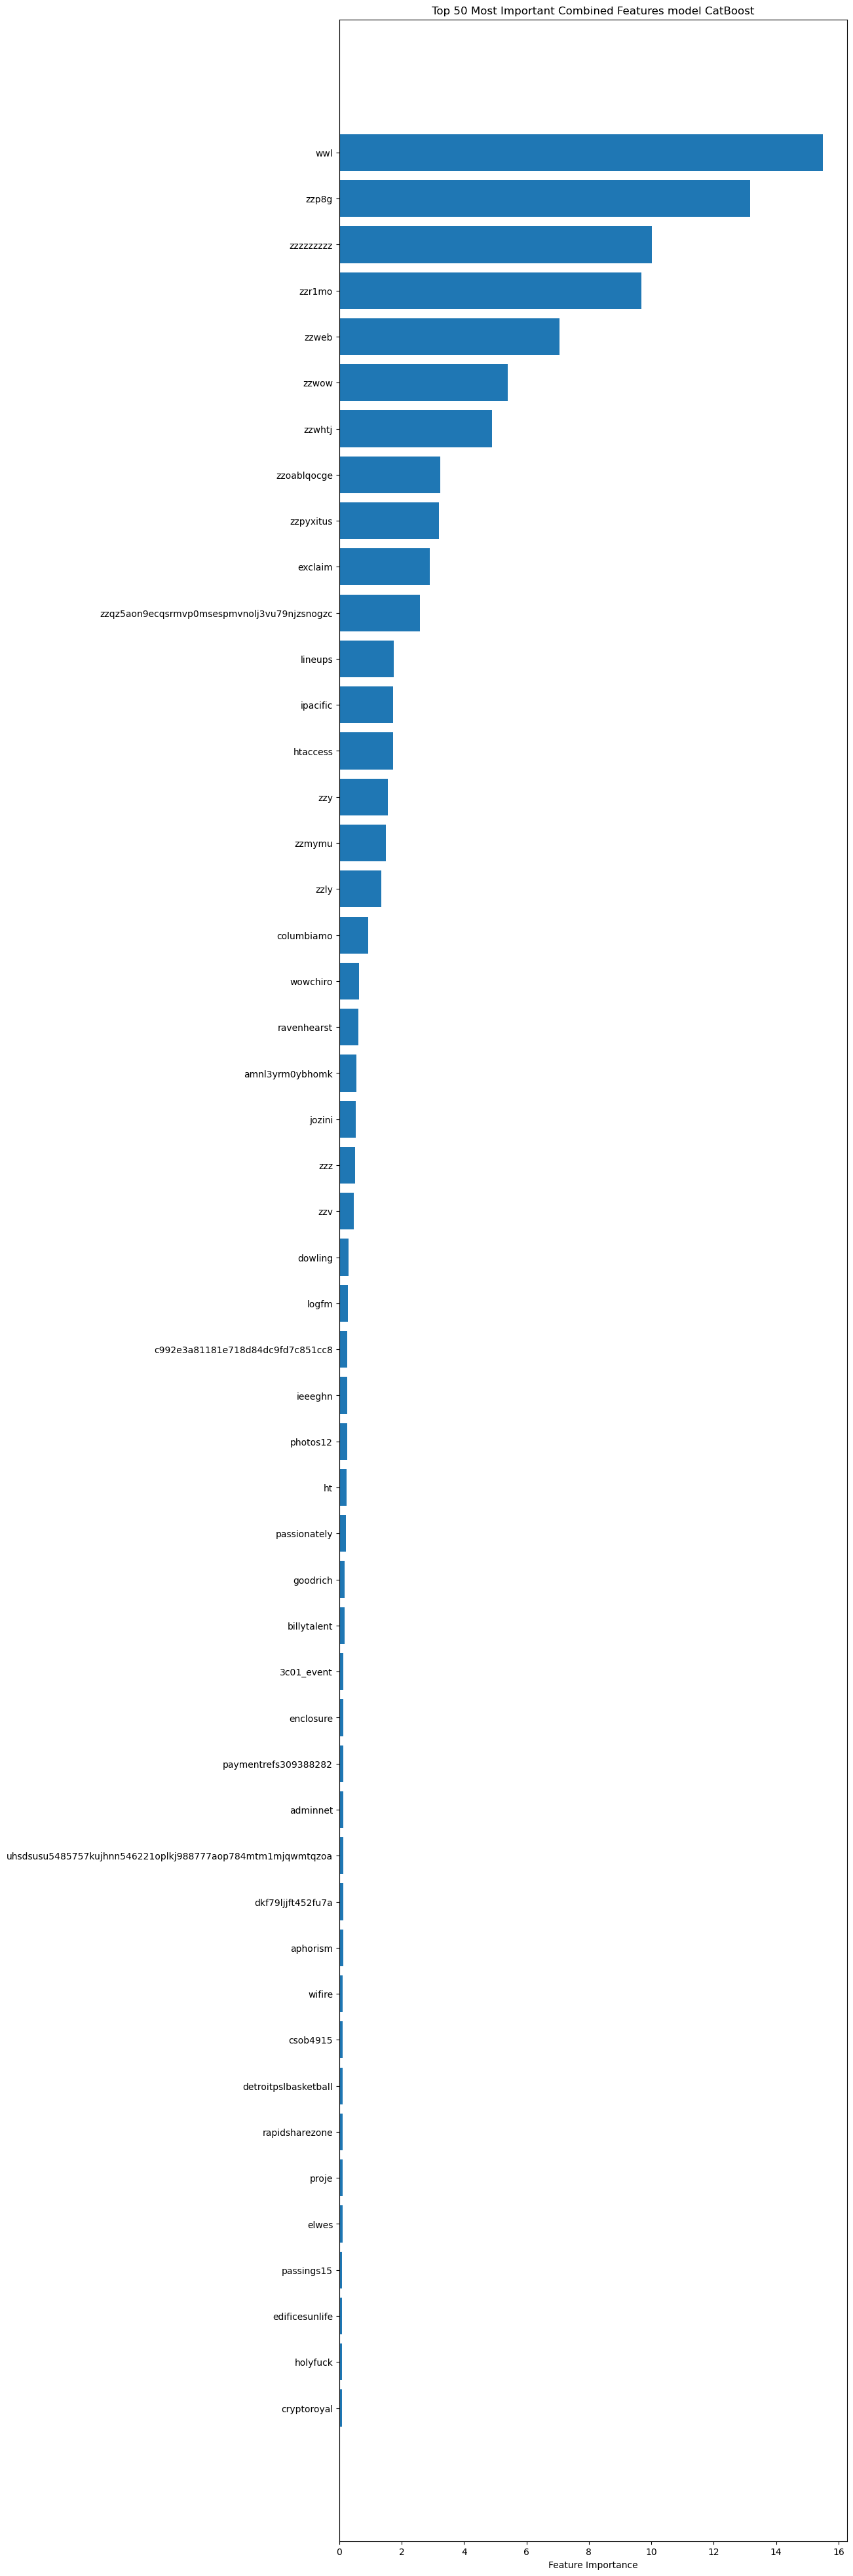

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping before filtering:", label_mapping)

    # Filter out spam cases
    spam_label = label_mapping.get('spam')  # Adjust this if the actual label differs
    if spam_label is not None:
        url_df = url_df[url_df['label'] != spam_label]
        text_data = url_df['tokens']
        # Update label encoding after filtering
        url_df['label'] = label_encoder.fit_transform(url_df['label'])
        label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Label mapping after filtering:", label_mapping)

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
         'url_length', 'domain_length', 'url_kl_divergence', 'num_special_symbols', 'contains_ip',
    'domain_kl_divergence', 'path_kl_divergence', 'query_kl_divergence', 'query_path_kl_divergence', 
    'presence_of_suspicious_file_extensions', 'sub_domains_count', 'digit_frequency', 
    'count_tlds', 'is_short_url','similar_domain'
    ]

    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])

    vectorizer = CountVectorizer()
    X_Bow = vectorizer.fit_transform(text_data)
    
    X_combined = hstack((X_Bow, other_features_scaled))

    return X_combined, url_df['label'], vectorizer, numerical_features

def initialize_and_fit_models(X_train, y_train):
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    ada_clf = AdaBoostClassifier()
    lgb_clf = lgb.LGBMClassifier()
    cat_clf = CatBoostClassifier(verbose=0)

    ensemble_clf = VotingClassifier(estimators=[
        ('xgb', xgb_clf), ('ada', ada_clf), ('lgb', lgb_clf), ('cat', cat_clf)
    ], voting='soft')

    models = {'XGBoost': xgb_clf, 'AdaBoost': ada_clf, 'LightGBM': lgb_clf, 'CatBoost': cat_clf, 'Ensemble': ensemble_clf}
    for name, model in models.items():
        model.fit(X_train, y_train)

    return models

from sklearn.metrics import confusion_matrix
import numpy as np


# Enhanced function to evaluate models and plot confusion matrices with labels
def enhanced_evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        error_rate = 1 - accuracy
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        
        results[name] = {
            'Accuracy': accuracy,
            'Error Rate': error_rate,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': fscore,
            'Confusion Matrix': cm
        }
        
        # Print results
        print(f"{name} - Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
        
        # Plotting the confusion matrix with labels
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    return results

# Visualization for overall comparison
def plot_model_comparisons(results):
    metrics = ['Accuracy', 'Error Rate', 'Precision', 'Recall', 'F1 Score']
    for metric in metrics:
        values = [results[name][metric] for name in results]
        sns.barplot(x=list(results.keys()), y=values)
        plt.title(f'Comparison of Models based on {metric}')
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.show()


def plot_feature_importances(clf, vectorizer, numerical_features,model_name, top_n=50):
    tfidf_features = vectorizer.get_feature_names_out()
    all_features = numerical_features + list(tfidf_features)

    feature_importances = clf.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    top_n_indices = sorted_idx[:top_n]
    top_n_importances = feature_importances[top_n_indices]
    top_n_features = np.array(all_features)[top_n_indices]

    plt.figure(figsize=(10, top_n))
    plt.barh(range(top_n), top_n_importances, align='center')
    plt.yticks(range(top_n), top_n_features)
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Combined Features model {model_name}')
    plt.show()

# Main workflow
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

models = initialize_and_fit_models(X_train, y_train)

model_metrics = enhanced_evaluate_models(models, X_test, y_test)

# Plot the comparison of models
plot_model_comparisons(model_metrics)

# Plot feature importance for a specific model, e.g., XGBoost
plot_feature_importances(models['XGBoost'], vectorizer, numerical_features,'XGBoost')
plot_feature_importances(models['AdaBoost'], vectorizer, numerical_features,'AdaBoost')
plot_feature_importances(models['LightGBM'], vectorizer, numerical_features,'LightGBM')
plot_feature_importances(models['CatBoost'], vectorizer, numerical_features,'CatBoost')




# AdaBoost Model - TF-IDF and DataExplorasion (SMOTE)

Label mapping: {'benign': 0, 'malware': 1, 'phishing': 2, 'spam': 3}


C:\Users\eilon\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


 AdaBoost - Accuracy: 0.7270, Error Rate: 0.2730, Precision: 0.5885, Recall: 0.7082, F1 Score: 0.6042


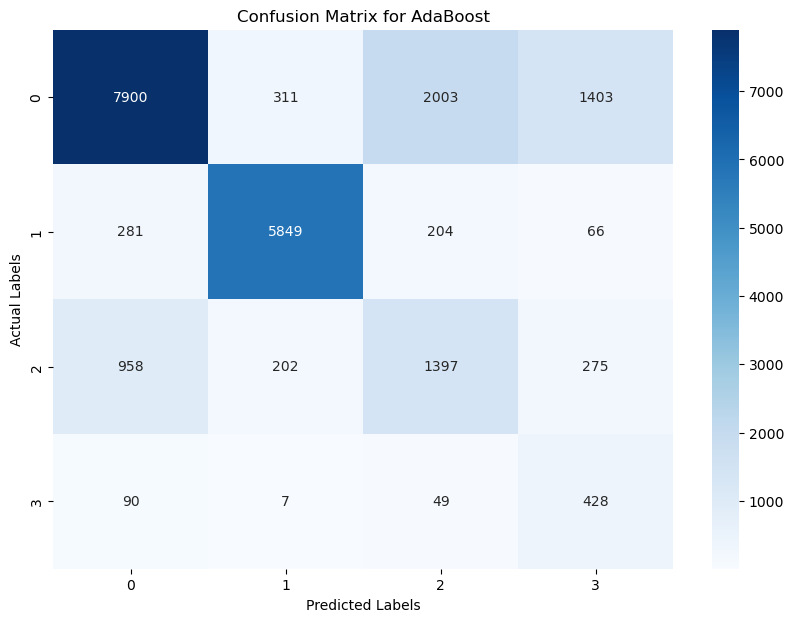

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_preprocess_data():
    url_df = pd.read_csv('smaller_url_dataset_features.csv')
    domain_df = pd.read_csv('domain.csv')

    if len(url_df) != len(domain_df):
        raise ValueError("The number of rows does not match between the datasets.")

    url_df['similar_domain'] = domain_df['similar_domain'].values
    text_data = url_df['tokens']
    label_encoder = LabelEncoder()
    url_df['label'] = label_encoder.fit_transform(url_df['label'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)

    return url_df, text_data, label_mapping

def extract_features(url_df, text_data):
    numerical_features = [
        'domain_length', 'url_kl_divergence', 'num_special_symbols',
        'domain_kl_divergence', 'path_kl_divergence', 'query_kl_divergence',
        'query_path_kl_divergence', 'presence_of_suspicious_file_extensions',
        'sub_domains_count', 'digit_frequency', 'count_tlds', 'similar_domain'
    ]
    
    scaler = StandardScaler()
    other_features_scaled = scaler.fit_transform(url_df[numerical_features])
    
    vectorizer = TfidfVectorizer(max_features=1000)  
    X_tfidf = vectorizer.fit_transform(text_data)

    X_combined = hstack((X_tfidf, other_features_scaled))

    return X_combined, url_df['label'], vectorizer, numerical_features

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

def train_adaboost_with_smote(X_train, y_train):
    ada_clf = AdaBoostClassifier()
    ada_clf.fit(X_train, y_train)
    return ada_clf

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    
    # Print results
    print(f" AdaBoost - Accuracy: {accuracy:.4f}, Error Rate: {error_rate:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {fscore:.4f}")
    
    # Plotting the confusion matrix with labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for AdaBoost')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Main workflow
url_df, text_data, label_mapping = load_and_preprocess_data()
X_combined, y, vectorizer, numerical_features = extract_features(url_df, text_data)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

X_train_res, y_train_res = apply_smote(X_train, y_train)
model = train_adaboost_with_smote(X_train_res, y_train_res)
evaluate_model(model, X_test, y_test)
